# **REDUÇÃO DO TEMPO DE ESPERA EM PORTOS: SEGMENTAÇÃO DE TERMINAIS VIA TÉCNICAS DE CLUSTERING**

---



**Matheus Henrique de Barros Ileck**

**Alexsandro Da Silva Bezerra**

**Alexandre Da Cunha Fernades**


# 1. **INTRODUÇÃO**
Os portos são fundamentais na logística global, movimentando mais de 80 % do comércio internacional em volume. e funcionando como hubs que conectam mercados, facilitando a distribuição de mercadorias e sustentando economias em escala mundial, para investigar essas possibilidades, o presente estudo se fundamenta em dados históricos de movimentação portuária, de 2005 a fevereiro de 2025.

O objetivo geral consiste em agrupar terminais portuários segundo perfis de movimentação de carga, visando ajudar na otimização logística e a redução do tempo de espera de navios, para atingir tal objetivo, realizamos um pré-processamento, limpeza, tratamento no conjunto de dados, seguindo de uma análise exploratória completa e então aplicar os modelos de agrupamentos, avaliamos a qualidade dos agrupamentos, escolhemos o vencedor e por fim interpretamos os clusters para formular recomendações operacionais e benchmarks entre terminais semelhantes.


**Importação e instalação das bibliotecas necessárias**


In [ ]:
!pip install dash

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, cophenet, fcluster, dendrogram

In [ ]:
df = pd.read_csv("APS_DADOS_ANUAIS_COMPLETO.csv",sep=';', encoding='latin-1')
display(df)

<ipython-input-92-037dc02a0f1a>:1: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



,Ano,Mês,DESC_SIMPLES,TIPO_INSTALAÇÃO (grupos),Terminal - GERIN,naturezacarga,TIPO_MOVIMENTO,navegacao,Sentido_carga,desc_spa,Toneladas,TEUs,Unidades
0,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,-,-
1,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,-,-
2,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,-,-
3,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,-,-
4,2005.0,1.0,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288430,2025.0,2.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.0,-,15
288431,2025.0,2.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,1.182,-,285
288432,2025.0,2.0,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,159.0,14,8
288433,2025.0,2.0,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,PRODUTOS DIVERSO,13.0,1,1


# 2. **METODOLOGIA**
O presente estudo utilizou um conjunto de dados fornecido pelo detentor da base, contendo registros de movimentação de cargas em terminais portuários, abrangendo o período de 2005 até fevereiro de 2025, organizados em arquivos no formato CSV, inicialmente, os arquivos foram importados para o ambiente Python por meio da biblioteca Pandas, o que permitiu a inspeção estrutural e a união dos distintos conjuntos de dados em um único DataFrame para posterior tratamento.


Na etapa de pré-processamento, procedeu-se à limpeza dos dados, removendo registros duplicados, corrigindo as colunas para seus devidos tipos, tratando valores ausentes

# Limpeza e pré-processamento

In [ ]:
# Padronização dos nomes das colunas e algumas linhas
df.columns = (
    df.columns
      .str.lower()
      .str.strip()
)
df['tipo_instalação (grupos)'] = df['tipo_instalação (grupos)'].replace({
    'TUP': 'TERMINAL DE USO PRIVADO'
})
display(df)

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
0,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,-,-
1,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,-,-
2,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,-,-
3,2005.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,-,-
4,2005.0,1.0,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288430,2025.0,2.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.0,-,15
288431,2025.0,2.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,1.182,-,285
288432,2025.0,2.0,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,159.0,14,8
288433,2025.0,2.0,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,PRODUTOS DIVERSO,13.0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288435 entries, 0 to 288434
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ano                       288417 non-null  float64
 1   mês                       288417 non-null  float64
 2   desc_simples              288417 non-null  object 
 3   tipo_instalação (grupos)  288417 non-null  object 
 4   terminal - gerin          288412 non-null  object 
 5   naturezacarga             288412 non-null  object 
 6   tipo_movimento            288412 non-null  object 
 7   navegacao                 288412 non-null  object 
 8   sentido_carga             288412 non-null  object 
 9   desc_spa                  288412 non-null  object 
 10  toneladas                 288417 non-null  object 
 11  teus                      288417 non-null  object 
 12  unidades                  288417 non-null  object 
dtypes: float64(2), object(11)
memory usage: 28.6

In [ ]:
# Verificando valores vazios
df.isnull().sum()

,0
ano,18
mês,18
desc_simples,18
tipo_instalação (grupos),18
terminal - gerin,23
naturezacarga,23
tipo_movimento,23
navegacao,23
sentido_carga,23
desc_spa,23


In [ ]:
null_rows = df[df['terminal - gerin'].isnull()]
display(null_rows)

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
137,2005.0,1.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,25.170,-,502.000
1256,2005.0,2.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,31.291,-,624.000
2395,2005.0,3.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,58.222,-,1.161.000
3547,2005.0,4.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,27.782,-,554.000
6872,2005.0,7.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,64.588,-,1.288.000
285937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_arm_2005 = df[(df['desc_simples'] == 'ARM 33') & (df['ano'] == 2005.0)]
df_arm_2005['unidades'] = df_arm_2005['unidades'].str.replace('.', '', regex=False)
df_arm_2005['unidades'] = df_arm_2005['unidades'].str.replace(',', '.', regex=False)

df_arm_2005['unidades'] = df_arm_2005['unidades'].astype(float)
display(df_arm_2005)

<ipython-input-97-df7959a04923>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-97-df7959a04923>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-97-df7959a04923>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
137,2005.0,1.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,25.170,-,502000.0
1256,2005.0,2.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,31.291,-,624000.0
2395,2005.0,3.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,58.222,-,1161000.0
3547,2005.0,4.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,27.782,-,554000.0
5791,2005.0,6.0,ARM 33,PORTO ORGANIZADO,DEICMAR,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,ACESSÓRIOS DE VE,9,-,1.0
5792,2005.0,6.0,ARM 33,PORTO ORGANIZADO,DEICMAR,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,7,-,2.0
5793,2005.0,6.0,ARM 33,PORTO ORGANIZADO,LOCALFRIO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,AÇÚCAR,3.194,-,63680.0
5794,2005.0,6.0,ARM 33,PORTO ORGANIZADO,NST,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,156,-,4.0
5795,2005.0,6.0,ARM 33,PORTO ORGANIZADO,TRANSBRASA,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,2.059,-,1036.0
6872,2005.0,7.0,ARM 33,PORTO ORGANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,64.588,-,1288000.0


In [ ]:
df_arm_2005['unidades'].describe()

,unidades
count,4.100000e+01
mean,1.042251e+05
std,2.966222e+05
min,1.000000e+00
25%,2.000000e+00
50%,4.400000e+01
75%,3.530000e+02
max,1.288000e+06


**Boxplot de 'unidades' do ano de 2005**

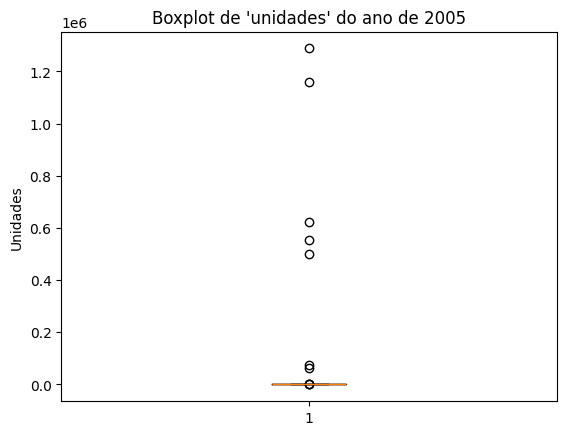

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(df_arm_2005['unidades'].dropna())
plt.title("Boxplot de 'unidades' do ano de 2005")
plt.ylabel("Unidades")
plt.show()

Primeiramente, identificamos que certas colunas como terminal, gerin, naturezacarga, tipo_movimento, navegacao, sentido_carga e desc_spa contêm linhas com valores ausentes (NaN) 5 registros juntando com as linhas completamente sem valores temos um total de 23 registros, o que representa cerca de 0,00797% do total do conjunto de dados. Esses registros não contribuem com informação e quando olhamos para as suas estatísticas, percebemos que vários valores se encontram acima da média possivelmente esses são outliers, confirmados pelo boxplot. Esses valores extremos podem influenciar de maneira significativa, comprometendo a interpretação da tendência central do conjunto, então excluir essas linhas é a melhor abordagem.

In [ ]:
# Excluindo essas linhas
idx_null_rows = null_rows.index
df.drop(idx_null_rows, inplace=True)

In [ ]:
df.isnull().sum()

,0
ano,0
mês,0
desc_simples,0
tipo_instalação (grupos),0
terminal - gerin,0
naturezacarga,0
tipo_movimento,0
navegacao,0
sentido_carga,0
desc_spa,0


In [ ]:
# Atribuindo os devidos valores para cada coluna
df['ano'] = df['ano'].astype(int)
df['mês'] = df['mês'].astype(int)
df['desc_simples'] = df['desc_simples'].astype(str)
df['tipo_instalação (grupos)'] = df['tipo_instalação (grupos)'].astype(str)
df['terminal - gerin'] = df['terminal - gerin'].astype(str)
df['naturezacarga'] = df['naturezacarga'].astype(str)
df['tipo_movimento'] = df['tipo_movimento'].astype(str)
df['navegacao'] = df['navegacao'].astype(str)
df['sentido_carga'] = df['sentido_carga'].astype(str)
df['desc_spa'] = df['desc_spa'].astype(str)

display(df)


,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
0,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,-,-
1,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,-,-
2,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,-,-
3,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,-,-
4,2005,1,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288430,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.0,-,15
288431,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,1.182,-,285
288432,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,159.0,14,8
288433,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,PRODUTOS DIVERSO,13.0,1,1


In [ ]:
valores_traco_toneladas_df = df[(df['toneladas'] == ' -   ')]
display(valores_traco_toneladas_df)

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
34065,2007,8,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),-,-,-
34066,2007,8,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,-,-,-


Apenas duas linhas, iremos exclui-las



In [ ]:
# Excluindo essas duas linhas
idx_valores_traco_toneladas_df_rows = valores_traco_toneladas_df.index
df.drop(idx_valores_traco_toneladas_df_rows, inplace=True)


Com isso, excluímos 25 linhas, o que representa aproximadamente 0,000087% do conjunto de dados.


In [ ]:
df[df['unidades'] == ' -   ']

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
0,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,-,-
1,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,-,-
2,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,-,-
3,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,-,-
4,2005,1,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288410,2025,2,TIPLAM 2,TERMINAL DE USO PRIVADO,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,EMBARQUE,SOJA EM GRÃOS,274.775,-,-
288411,2025,2,TIPLAM 3,TERMINAL DE USO PRIVADO,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,EMBARQUE,AÇÚCAR,205.448,-,-
288412,2025,2,TIPLAM 4,TERMINAL DE USO PRIVADO,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,FERTILIZANTES (M,17.524,-,-
288413,2025,2,TIPLAM 4,TERMINAL DE USO PRIVADO,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,FERTILIZANTES NI,106.267,-,-


In [ ]:
df[df['teus'] == ' -   ']

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
0,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,-,-
1,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,-,-
2,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,-,-
3,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,-,-
4,2005,1,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288415,2025,2,USIMINAS 3,TERMINAL DE USO PRIVADO,USIMINAS,CARGA GERAL,CONVENCIONAL,CABOTAGEM,EMBARQUE,PRODUTOS SIDERÚR,21.282,-,1.844
288428,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,1.745,-,435
288429,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,VEÍCULOS AUTOMÓV,536.0,-,42
288430,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.0,-,15


O sinal "-" indica ausência de carga conteinerizada. Para atribuirmos o tipo correto à coluna, possibilitar os cálculos e, posteriormente, o treinamento dos modelos, substituir esse valor por zero parece ser a escolha mais adequada.

In [ ]:
df['unidades'] = (
    df['unidades']
      .str.strip()
      .str.replace('.', '', regex=False)
      .str.replace(',', '.', regex=False)
      .str.replace('-', '0', regex=False))

df['teus'] = (
    df['teus']
      .str.strip()
      .str.replace('.', '', regex=False)
      .str.replace(',', '.', regex=False)
      .str.replace('-', '0', regex=False))

display(df)

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades
0,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,0,0
1,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,0,0
2,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,0,0
3,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,0,0
4,2005,1,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288430,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.0,0,15
288431,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,1.182,0,285
288432,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,159.0,14,8
288433,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,PRODUTOS DIVERSO,13.0,1,1


In [ ]:
# Atribuindo os devidos valores para cada coluna
df['toneladas'] = df['toneladas'].astype(float)
df['unidades'] = df['unidades'].astype(int)
df['teus'] = df['teus'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288410 entries, 0 to 288434
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ano                       288410 non-null  int64  
 1   mês                       288410 non-null  int64  
 2   desc_simples              288410 non-null  object 
 3   tipo_instalação (grupos)  288410 non-null  object 
 4   terminal - gerin          288410 non-null  object 
 5   naturezacarga             288410 non-null  object 
 6   tipo_movimento            288410 non-null  object 
 7   navegacao                 288410 non-null  object 
 8   sentido_carga             288410 non-null  object 
 9   desc_spa                  288410 non-null  object 
 10  toneladas                 288410 non-null  float64
 11  teus                      288410 non-null  int64  
 12  unidades                  288410 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 

**A ANÁLISE EXPLORATÓRIA DE DADOS (EDA)** incluiu a geração de estatísticas descritivas (média, mediana, quartis) e a construção de visualizações gráficas como boxplots, colunas, barras, linhas, pizza e entre outros para avaliar a distribuição das variáveis, possíveis correlações e a presença de outliers.

In [ ]:
contagens_terminais = df['terminal - gerin'].value_counts()

percentuais_terminais = df['terminal - gerin'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_terminal = pd.DataFrame({
    'contagem': contagens_terminais,
    'percentual (%)': percentuais_terminais.round(2)
})

display(resumo_terminal)

,contagem,percentual (%)
terminal - gerin,,
SANTOS BRASIL,93704,32.49
BTP,41851,14.51
DPWORLD (EMBRAPORT),32442,11.25
LIBRA 35,29056,10.07
ECOPORTO,17804,6.17
...,...,...
LIBRA 33,18,0.01
trsp,12,0.00
SANTOS BRASIL (SSZ35.2 Saboó),9,0.00


Os cinco primeiros terminais do dataframe acima representam aproximadamente 75% do conjunto de dados. Iremos utilizá-los como uma amostra representativa na análise exploratória a seguir, especialmente para a visualização dos gráficos, já que é inviável gerar visualizações com todos os 74 terminais.

In [ ]:
top_5_terminais = resumo_terminal.head(5)
top_5_terminais.loc['OUTROS'] = {
    'contagem': 73551,
    'percentual (%)': 25.51
}
top5 = ["SANTOS BRASIL", "BTP", "DPWORLD (EMBRAPORT)", "LIBRA 35", "ECOPORTO"]
df_top5 = df[df['terminal - gerin'].isin(top5)]
display(top_5_terminais)

<ipython-input-110-4c5436d555e4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,contagem,percentual (%)
terminal - gerin,,
SANTOS BRASIL,93704,32.49
BTP,41851,14.51
DPWORLD (EMBRAPORT),32442,11.25
LIBRA 35,29056,10.07
ECOPORTO,17804,6.17
OUTROS,73551,25.51


Agrupamos os outros 69 terminais em uma categoria "OUTROS" para viabilizar sua visualização de forma consolidada nos gráficos.

# Gráfico da Distribuição dos Terminais em Contagem e Percentual

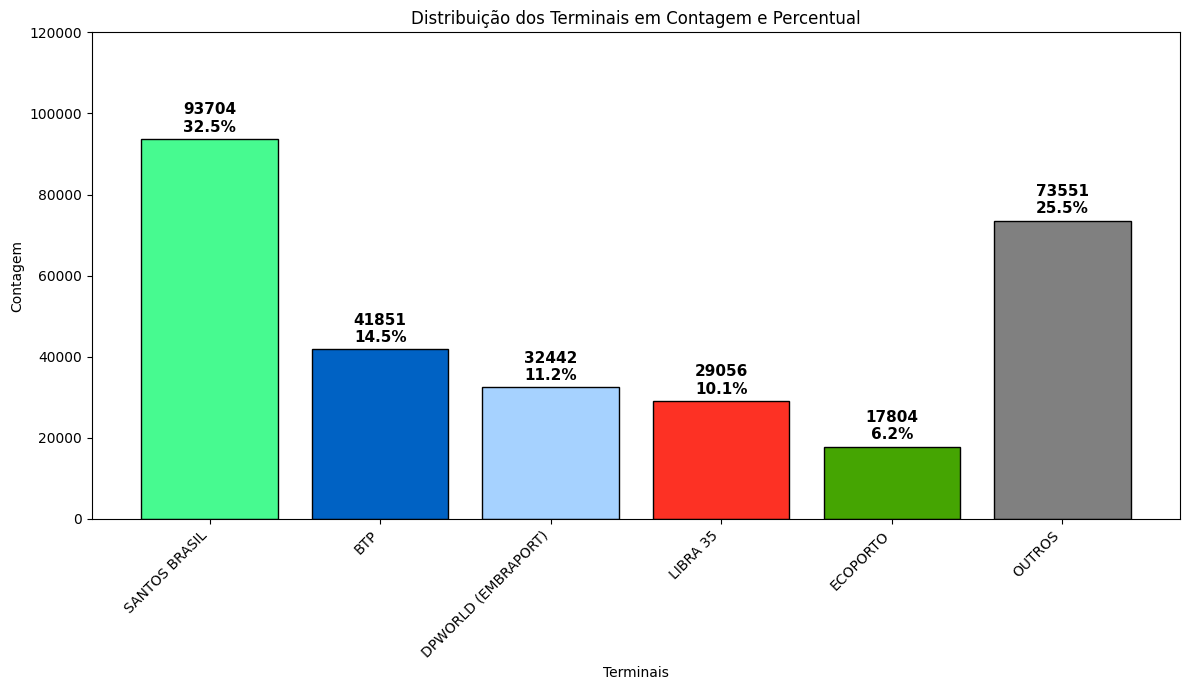

In [ ]:
cores = {
    'SANTOS BRASIL': '#47fa90',
    'BTP': '#0062c4',
    'DPWORLD (EMBRAPORT)': '#a6d2ff',
    'LIBRA 35':'#fd3124',
    'ECOPORTO':'#45a502',
    'OUTROS': 'grey'

}


fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(
    top_5_terminais.index,
    top_5_terminais['contagem'],
    edgecolor='black',
    color=[cores[label] for label in top_5_terminais.index]
)

for bar, cnt, pct in zip(bars, top_5_terminais['contagem'], top_5_terminais['percentual (%)']):
    height = bar.get_height()
    ax.annotate(
        f'{cnt}\n{pct:.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=11,
        fontweight='bold'
    )


ax.set_xlabel('Terminais')
ax.set_ylabel('Contagem')
ax.set_title('Distribuição dos Terminais em Contagem e Percentual')
ax.set_ylim(0, 120000)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

O que mais se Destaca no gráfico acima e o terminal da SANTOS BRASIL, com 32,5 % dos registros, supera em mais que o dobro o segundo colocado (BTP), o que indica uma forte concentração de dados nesse único terminal, isso pode se dar por ser um terminal mais velho e consolidado. Ainda assim, BTP, DPWORLD e LIBRA 35 mantêm percentuais relativamente próximos entre si (de 10 % a 14 %), mostrando que, apesar de menores que Santos, formam um grupo intermediário relevante e por fim temos a ECOPORTO com 6,2%. Vale ressaltar que os outros 69 terminais, agrupados como “OUTROS”, estão nesse gráfico apenas para visualização e não comparação entre os outros terminais.

In [ ]:
contagens_instalacao = df['tipo_instalação (grupos)'].value_counts()

percentuais_instalacao  = df['tipo_instalação (grupos)'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_instalacao  = pd.DataFrame({
    'contagem': contagens_instalacao ,
    'percentual (%)': percentuais_instalacao.round(2)
})

display(resumo_instalacao)

,contagem,percentual (%)
tipo_instalação (grupos),,
PORTO ORGANIZADO,250424,86.83
TERMINAL DE USO PRIVADO,37986,13.17


# Gráfico da distribuição de Tipos de Instalação Portuária (2005 até feveiro 2025)

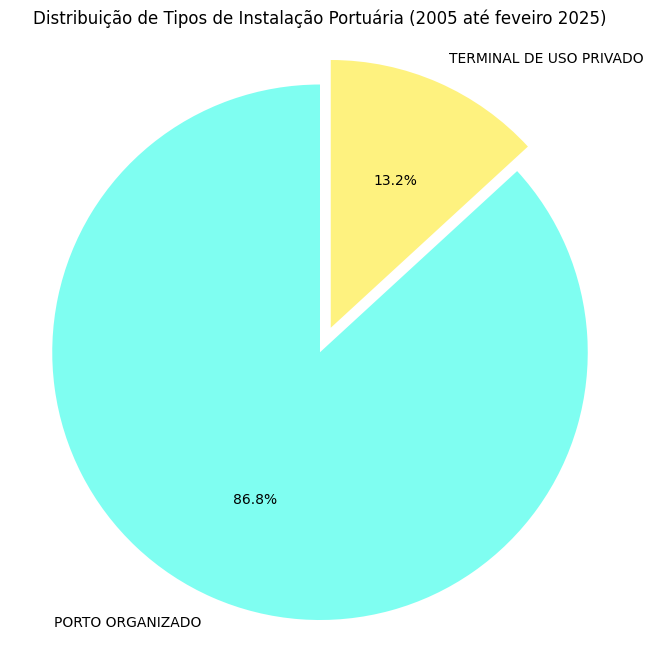

In [ ]:
cores = {
    'PORTO ORGANIZADO': '#7ffef1',
    'TERMINAL DE USO PRIVADO': '#fef27f'
}

explode = [0.1 if label == 'PORTO ORGANIZADO' else 0 for label in resumo_instalacao.index]

plt.figure(figsize=(8, 8))
plt.pie(
    resumo_instalacao['contagem'],
    labels=resumo_instalacao.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[cores[label] for label in resumo_instalacao.index],
    explode=explode
)
plt.title('Distribuição de Tipos de Instalação Portuária (2005 até feveiro 2025)')
plt.axis('equal')
plt.show()

Olhando para gráfico acima percebemos que a esmagadora maioria dos registros (86,8 %) corresponde a “Porto Organizado”, enquanto apenas 13,2 % se refere a “Terminal de Uso Privado”. Indicando que ao longo dos vinte anos, as operações concentraram-se predominantemente em instalações públicas ou oficiais reguladas pelo sistema de portos organizado, ficando uma parcela menor, ainda que relevante, nas regiões classificadas como terminais privados.

In [ ]:
contagens_naturezacarga = df['naturezacarga'].value_counts()

percentuais_naturezacarga  = df['naturezacarga'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_naturezacarga  = pd.DataFrame({
    'contagem': contagens_naturezacarga ,
    'percentual (%)': percentuais_naturezacarga.round(2)
})

display(resumo_naturezacarga)

,contagem,percentual (%)
naturezacarga,,
CARGA CONTEINERIZADA,238400,82.66
GRANEL LIQUIDO,23124,8.02
CARGA GERAL,14154,4.91
GRANEL SOLIDO,12732,4.41


Gráfico da distribuição de Tipos de Carga com Contagem e Percentual (2005 até feveiro 2025)

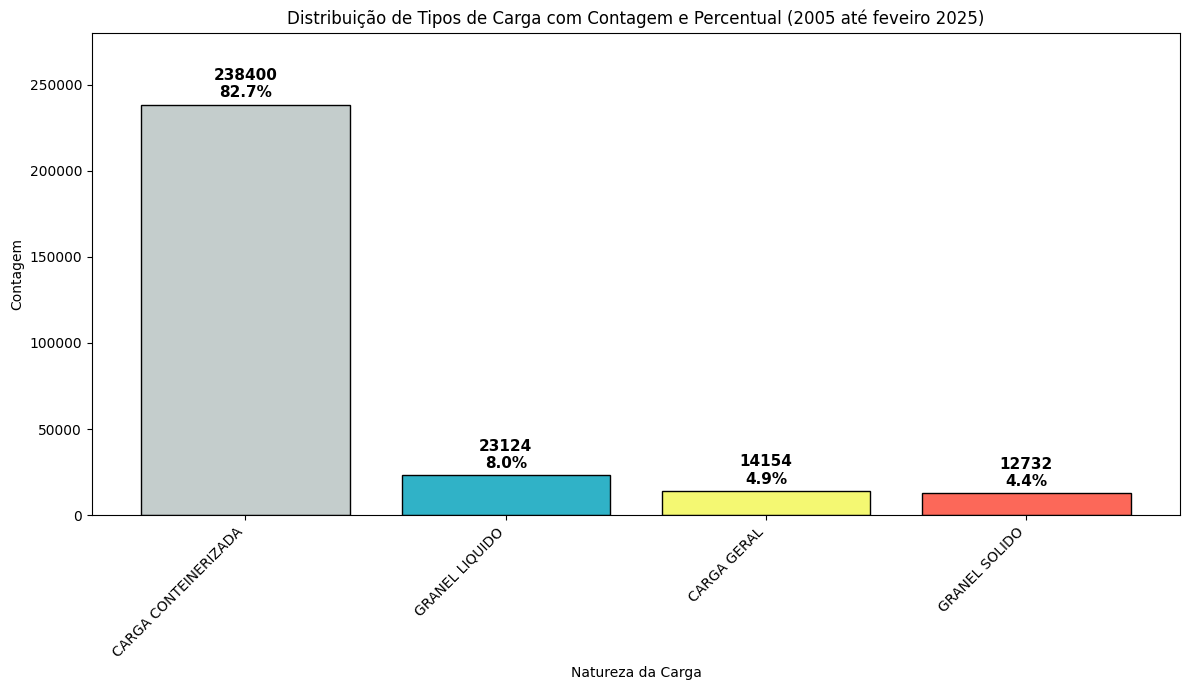

In [ ]:
cores = {
    'CARGA CONTEINERIZADA': '#c4cdcc',
    'GRANEL LIQUIDO': '#30b2c7',
    'CARGA GERAL': '#f4f872',
    'GRANEL SOLIDO': '#fc6859'
}

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(
    resumo_naturezacarga.index,
    resumo_naturezacarga['contagem'],
    edgecolor='black',
    color=[cores[label] for label in resumo_naturezacarga.index]
)

for bar, cnt, pct in zip(bars, resumo_naturezacarga['contagem'], resumo_naturezacarga['percentual (%)']):
    height = bar.get_height()
    ax.annotate(
        f'{cnt}\n{pct:.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=11,
        fontweight='bold'
    )


ax.set_xlabel('Natureza da Carga')
ax.set_ylabel('Contagem')
ax.set_title('Distribuição de Tipos de Carga com Contagem e Percentual (2005 até feveiro 2025)')
ax.set_ylim(0, 280000)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 Olhando para o gráfico acima percebemos que há uma dominância por cargas conteinerizadas, com 238.400 registros, equivalentes a 82,7 % do total. Em contraste, os demais tipos de carga, granel líquido (8,0 %), carga geral (4,9 %) e granel sólido (4,4 %)—somam conjuntamente apenas 17,3 % das observações.

 é uma visualização importante assim como a de Distribuição de Tipos de Instalação Portuária, porque com a dominãncia das cargas conteinerizadas acima como a do porto organizado pode acabar "ofuscando” os padrões característicos das demais cargas.



# Gráfico da composição 100% Empilhada por Natureza de Carga – Top 5 Terminais

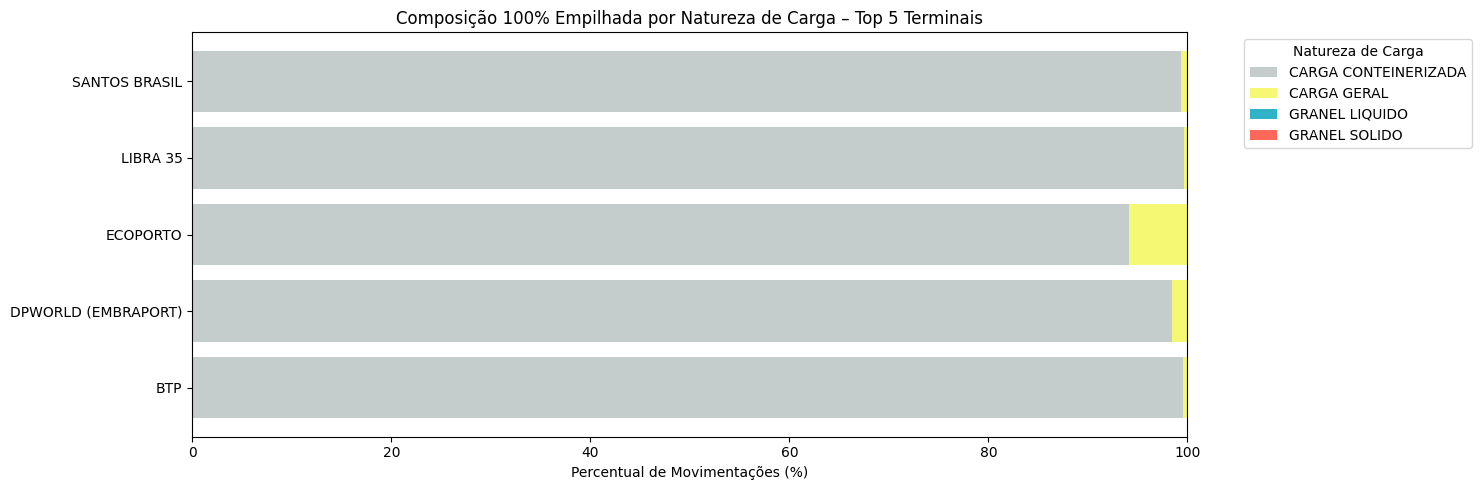

In [ ]:
comp_carga = (
    df_top5
    .groupby(['terminal - gerin', 'naturezacarga'])
    .size()
    .reset_index(name='count')
)
totais_por_terminal = (
    comp_carga
    .groupby('terminal - gerin')['count']
    .sum()
    .rename('total_count')
)
comp_carga = comp_carga.merge(totais_por_terminal, on='terminal - gerin')
comp_carga['percentual'] = 100 * comp_carga['count'] / comp_carga['total_count']

pivot_carga = comp_carga.pivot_table(
    index='terminal - gerin',
    columns='naturezacarga',
    values='percentual',
    fill_value=0
)

naturezas = list(pivot_carga.columns)
terminais = pivot_carga.index.tolist()
y_pos = np.arange(len(terminais))


plt.figure(figsize=(15, 5))
bottom = np.zeros(len(terminais))

for nat in naturezas:
    vals = pivot_carga[nat].values
    plt.barh(
        y=y_pos,
        width=vals,
        left=bottom,
        color=cores[nat],
        label=nat
    )
    bottom += vals

plt.yticks(y_pos, terminais)
plt.xlabel('Percentual de Movimentações (%)')
plt.title('Composição 100% Empilhada por Natureza de Carga – Top 5 Terminais')
plt.xlim(0, 100)
plt.legend(title='Natureza de Carga', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Em SANTOS BRASIL, BTP e LIBRA 35, praticamente 100 % do volume anual registrado entre 2005 e fevereiro de 2025 corresponde a contêineres. Dá para perceber apenas uma finíssima faixa amarelada (carga geral) que, estatisticamente, representa menos de 1 % em cada um desses operadores principais. Ou seja, esses três terminais funcionam como hubs quase que integralmente voltados à logística conteinerizada, sem destinar espaço expressivo a granéis líquidos, granéis sólidos ou carga geral.

Embora ECOPORTO e DPWORLD (EMBRAPORT) também sejam majoritariamente conteinerizados (cerca de 90 % a 95 % de suas operações), ambos exibem uma fatia ligeiramente maior de carga geral (a parte amarela)  estima-se algo na faixa de 3 % a 7 %. As porções correspondentes a granel líquido (azul-turquesa) e granel sólido (vermelho) são praticamente imperceptíveis nesses dois terminais. Isso significa que, diferentemente de SANTOS BRASIL, BTP e LIBRA 35, ECOPORTO e DPWORLD mantém uma mínima diversificação em relação ao tipo de carga, operando um pequeno volume de carga geral para além dos contêineres.

In [ ]:
contagens_tipo_movimento = df['tipo_movimento'].value_counts()

percentuais_tipo_movimento  = df['tipo_movimento'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_tipo_movimento  = pd.DataFrame({
    'contagem': contagens_tipo_movimento ,
    'percentual (%)': percentuais_tipo_movimento.round(2)
})

display(resumo_tipo_movimento)

,contagem,percentual (%)
tipo_movimento,,
CONVENCIONAL,185851,64.44
TRANSBORDO,78409,27.19
REMOÇÃO,22787,7.90
CONTRABORDO,979,0.34
MALOGRO,384,0.13


# Gráfico da distribuição da movimentação da carga com Contagem e Percentual (2005 até feveiro 2025)

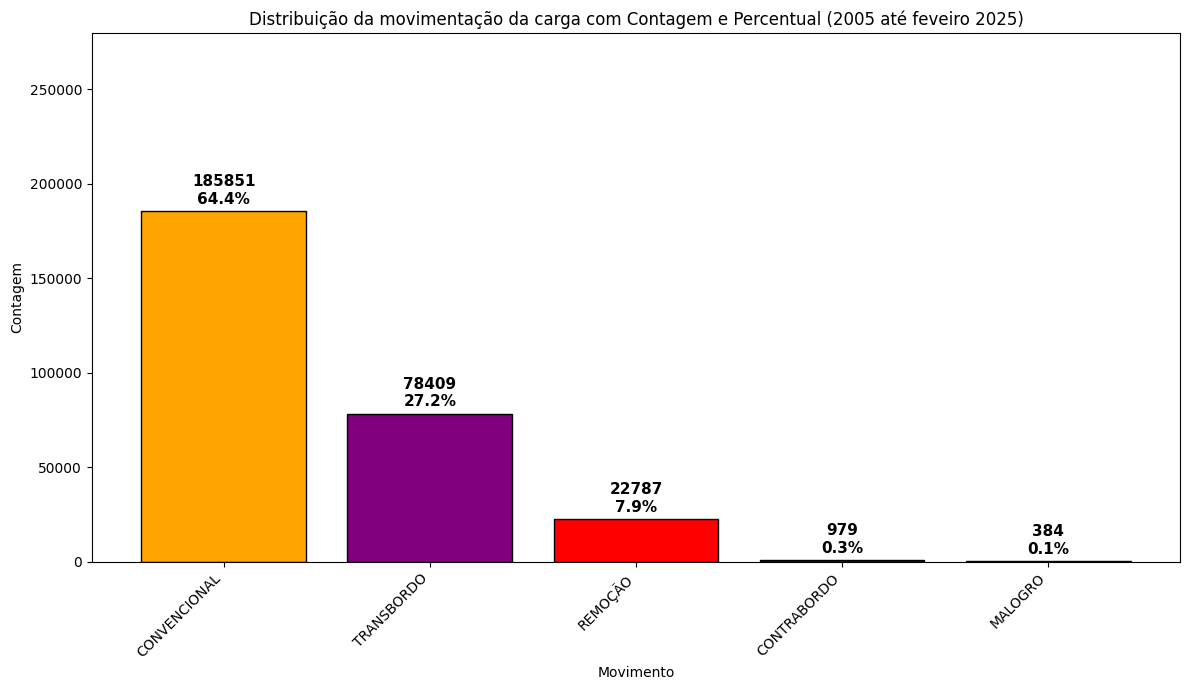

In [ ]:
cores = {
    'CONTRABORDO': 'blue',
    'CONVENCIONAL': 'orange',
    'MALOGRO': 'green',
    'REMOÇÃO': 'red',
    'TRANSBORDO': 'purple'
}

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(
    resumo_tipo_movimento.index,
    resumo_tipo_movimento['contagem'],
    edgecolor='black',
    color=[cores[label] for label in resumo_tipo_movimento.index]
)

for bar, cnt, pct in zip(bars, resumo_tipo_movimento['contagem'], resumo_tipo_movimento['percentual (%)']):
    height = bar.get_height()
    ax.annotate(
        f'{cnt}\n{pct:.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=11,
        fontweight='bold'
    )


ax.set_xlabel('Movimento')
ax.set_ylabel('Contagem')
ax.set_title('Distribuição da movimentação da carga com Contagem e Percentual (2005 até feveiro 2025)')
ax.set_ylim(0, 280000)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

O gráfico mostra que, ao longo de todo o período, a esmagadora maioria das operações se enquadra em “Convencional” (185.851 registros, ou 64,4 %), seguida por “Transbordo” (78.409 registros, 27,2 %) e “Remoção” (22.787 registros, 7,9 %). As modalidades “Contrabordo” (979 registros, 0,3 %) e “Malogro” (384 registros, 0,1 %) são praticamente residuais.

Essa concentração de quase dois terços em operações convencionais, somada a mais de um quarto de transbordo, revela que a dinâmica portuária, no agregado, está dominada por cargas que entram ou saem do porto em rotas de importação/exportação (convencional) e por um volume expressivo de movimentação interna de contêineres (transbordo). As remessas via remoção geralmente relacionadas a reposicionamento de contêineres vazios representam um patamar relevante (quase 8 %), enquanto contrabordo (troca lateral de cargas entre navios) e malogro (registros de carga danificada ou perdida) praticamente não alteram o cenário agregado

# Gráfico de distribuição de Tipos de Movimento por Natureza de Carga (Percentuais) (2005 até feveiro 2025)

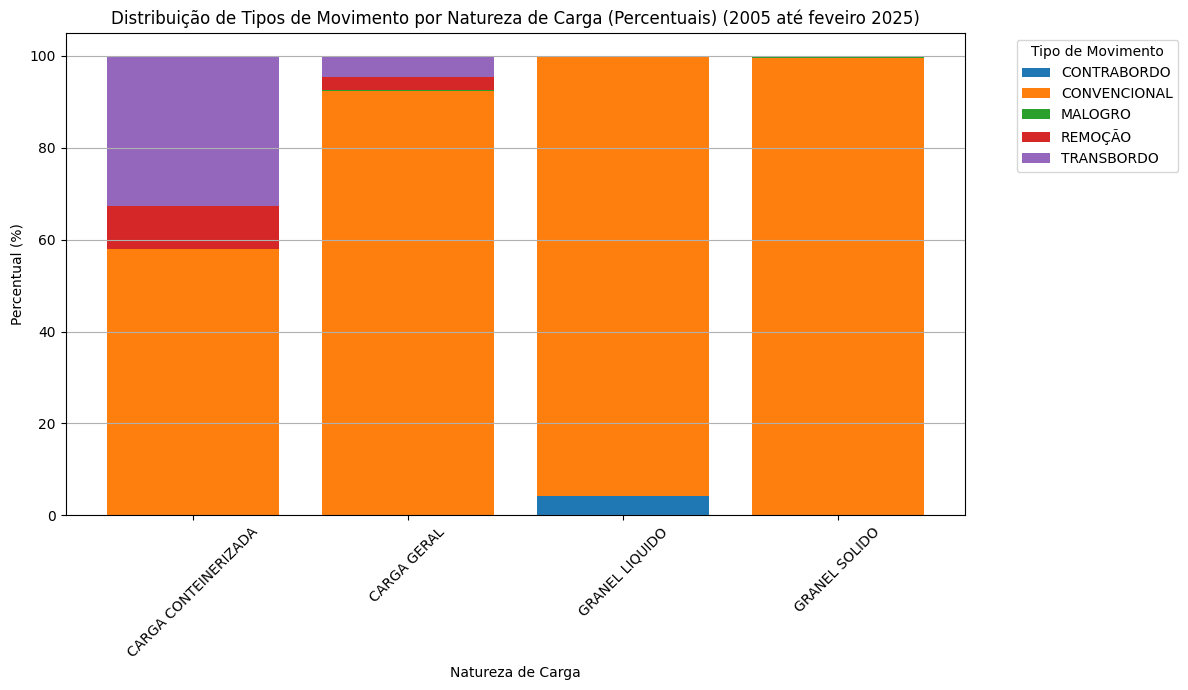

In [ ]:
grouped_counts = df.groupby(['naturezacarga', 'tipo_movimento']).size().reset_index(name='contagem')
grouped_percentages = grouped_counts.copy()
grouped_percentages['percentual'] = grouped_percentages.groupby('naturezacarga')['contagem'].transform(lambda x: (x / x.sum()) * 100)


pivot_pct = grouped_percentages.pivot_table(
    index='naturezacarga',
    columns='tipo_movimento',
    values='percentual',
    aggfunc='sum',
    fill_value=0
)

fig, ax = plt.subplots(figsize=(12,7))
bottom = pd.Series([0]*len(pivot_pct), index=pivot_pct.index)

for movimento in pivot_pct.columns:
    ax.bar(
        pivot_pct.index,
        pivot_pct[movimento],
        bottom=bottom,
        label=movimento
    )
    bottom += pivot_pct[movimento]

ax.set_xlabel('Natureza de Carga')
ax.set_ylabel('Percentual (%)')
ax.set_title('Distribuição de Tipos de Movimento por Natureza de Carga (Percentuais) (2005 até feveiro 2025)')
ax.legend(title='Tipo de Movimento', bbox_to_anchor=(1.05,1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

O gráfico que relaciona tipos de movimento e natureza de carga revela que a carga conteinerizada apresenta distribuição mais diversificada de operações, com cerca de 60 % de movimentações convencionais, 30 % de transbordo e 10 % de remoção, enquanto as categorias de granel líquido, carga geral e granel sólido concentram-se quase inteiramente em operações convencionais e apresentam volumes residuais de transbordo, remoção ou contrabordo.

Essa diferença operacional indica que, para agrupar terminais de forma eficaz, é essencial considerar não apenas o tipo de carga, mas também o perfil de movimentação de cada terminal, pois hubs conteinerizados intensivos—com altos índices de transbordo e remoção funcionam de maneira diferente de terminais dedicados a graneis, que operam quase exclusivamente em modo convencional.

# Gráfico da composição 100% Empilhada por Tipo de Movimento da Carga – Top 5 Terminais

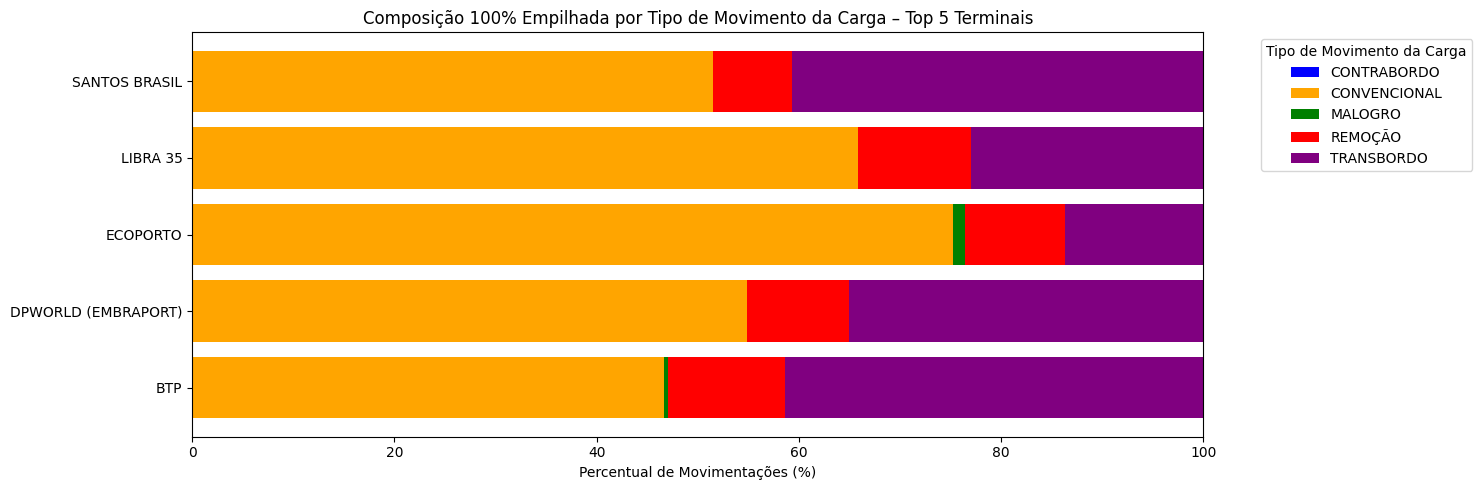

In [ ]:
comp_mov = (
    df_top5
    .groupby(['terminal - gerin', 'tipo_movimento'])
    .size()
    .reset_index(name='count')
)

totais_por_terminal = (
    comp_carga
    .groupby('terminal - gerin')['count']
    .sum()
    .rename('total_count')
)

comp_mov = comp_mov.merge(
    totais_por_terminal,
    on='terminal - gerin'
)

comp_mov['percentual'] = 100 * comp_mov['count'] / comp_mov['total_count']

pivot_mov = comp_mov.pivot_table(
    index='terminal - gerin',
    columns='tipo_movimento',
    values='percentual',
    fill_value=0
)

naturezas = list(pivot_mov.columns)

terminais = pivot_mov.index.tolist()
y_pos = np.arange(len(terminais))

bottom = np.zeros(len(terminais))

plt.figure(figsize=(15, 5))


for nat in naturezas:
    vals = pivot_mov[nat].values
    plt.barh(
        y=y_pos,
        width=vals,
        left=bottom,
        color=cores[nat],
        label=nat
    )
    bottom += vals


plt.yticks(y_pos, terminais)
plt.xlabel('Percentual de Movimentações (%)')
plt.title('Composição 100% Empilhada por Tipo de Movimento da Carga – Top 5 Terminais')
plt.xlim(0, 100)
plt.legend(title='Tipo de Movimento da Carga', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


O gráfico de composição empilhada por tipo de movimento da carga para os cinco principais terminais revela que a movimentação convencional continua sendo predominante em todos eles, mas que há diferenças significativas na participação de remoção e transbordo, o que reflete a estratégia operacional de cada terminal.

Na Santos Brasil observa-se uma distribuição em que a movimentação convencional corresponde a pouco mais da metade do total, seguida por uma fatia considerável de transbordo e uma parcela intermediária de remoção, indicando que esse terminal atua tanto como ponto de importação e exportação direta quanto como hub para transferência de contêineres e alocação de unidades vazias. Esse mix sugere uma operação complexa, em que Santos Brasil equilibra intensamente a recepção de carga convencional com atividades de redistribuição de contêineres.

BTP exibe um perfil levemente distinto, com movimentação convencional ainda dominante mas com uma proporção de remoção ligeiramente superior à de transbordo, o que aponta para uma maior ênfase na logística de gerenciamento de contêineres vazios, possivelmente em função de sua localização estratégica para rotas de distribuição interna após receber e despachar carga internacional. A parte de transbordo em BTP, embora relevante, é um pouco menor do que em Santos Brasil, sugerindo que ele não atua tanto como ponto de relevo para hubs de consolidação entre navios de grandes porte, mas concentra-se mais em operações convencionais e em liberar contêineres para outras rotas.

No caso de Libra 35, a movimentação convencional continua sendo a parcela majoritária, porém a remoção ganha destaque, aproximando-se de patamares semelhantes aos observados em BTP, enquanto o transbordo ocupa a terceira posição em termos de proporção. Esse padrão reforça a ideia de que Libra 35, apesar de movimentar grandes volumes de carga de importação e exportação, possui uma logística interna eficiente de retromovimentação de contêineres vazios, característica fundamental para manter o ritmo de operações em um terminal dedicado à carga conteinerizada de grande escala.

Ecoporto, embora ainda seja um operador voltado predominantemente à movimentação convencional, apresenta a menor parcela de transbordo entre os cinco, mas compensa com uma fatia maior de remoção, indicando uma operação que privilegia a gestão de contêineres vazios em solo e menos transferência direta entre embarcações. Esse perfil sugere que Ecoporto pode ter menos aptidão para receber navios de grande porte para transbordo, concentrando-se mais em receber, descarregar e encaminhar contêineres para outros terminais ou modais interiores.

DPWorld (Embraport) mostra um padrão muito semelhante ao de Santos Brasil, com movimentação convencional em torno de metade do total, seguida por uma parcela significativa de transbordo e remoção em segundo e terceiro lugares, respectivamente. Isso reflete sua função como um hub internacional de alto fluxo, onde a transferência de contêineres entre navios ocorre em escala elevada, e a reposição de unidades vazias também tem importância estratégica para garantir a continuidade das cadeias logísticas. Assim, enquanto Santos Brasil e DPWorld se destacam como centros de transbordo e remoção intensivos, BTP, Libra 35 e Ecoporto mantêm um foco maior na movimentação convencional e na logística de remoção.

In [ ]:
contagens_navegacao = df['navegacao'].value_counts()

percentuais_navegacao  = df['navegacao'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_navegacao  = pd.DataFrame({
    'contagem': contagens_navegacao,
    'percentual (%)': percentuais_navegacao.round(2)
})

display(resumo_navegacao)

,contagem,percentual (%)
navegacao,,
LONGO CURSO,222377,77.1
CABOTAGEM,66033,22.9


# Gráfico da distribuição de Tipos de Navegação (2005 até feveiro 2025)

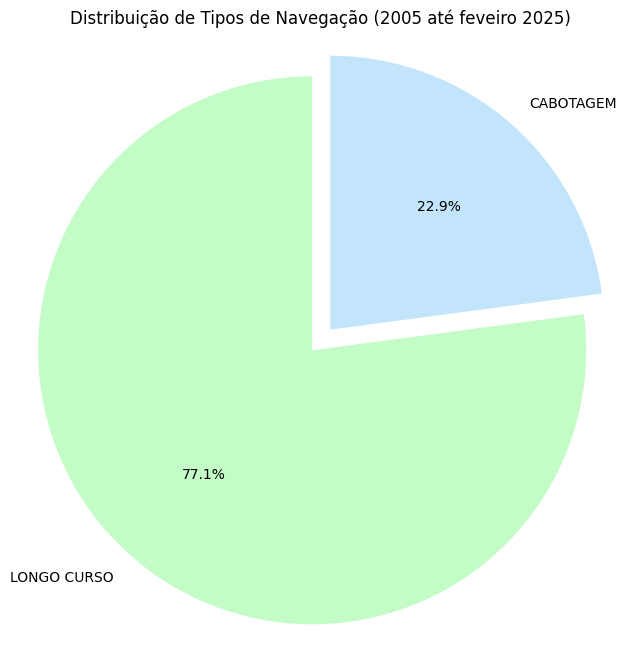

In [ ]:
cores = {
    'LONGO CURSO': '#c3fcc6',
    'CABOTAGEM': '#c3e5fc'
}

explode = [0.1 if label == 'LONGO CURSO' else 0 for label in resumo_navegacao.index]

plt.figure(figsize=(8, 8))
plt.pie(
    resumo_navegacao['contagem'],
    labels=resumo_navegacao.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[cores[label] for label in resumo_navegacao.index],
    explode=explode
)
plt.title('Distribuição de Tipos de Navegação (2005 até feveiro 2025)')
plt.axis('equal')
plt.show()

O gráfico evidencia que a maior parte das operações, cerca de 77%, está associada à navegação de longo curso, enquanto aproximadamente 23% corresponde a cabotagem, indicando que os terminais movimentam predominantemente cargas vinculadas a rotas internacionais ou de longa distância no comércio exterior, o que já era de se esperar dada as análises acima. Ao mesmo tempo, a fatia de cabotagem, embora menor, ainda representa uma parcela relevante, sinalizando que há um volume considerável de movimentação de cargas entre portos domésticos, o que reforça a dinâmica de distribuição interna de mercadorias.

In [ ]:
contagens_sentido_carga = df['sentido_carga'].value_counts()

percentuais_sentido_carga  = df['sentido_carga'] \
                .value_counts(normalize=True) \
                .mul(100)
resumo_sentido_carga  = pd.DataFrame({
    'contagem': contagens_sentido_carga,
    'percentual (%)': percentuais_sentido_carga.round(2)
})

display(resumo_sentido_carga)

,contagem,percentual (%)
sentido_carga,,
DESEMBARQUE,145698,50.52
EMBARQUE,141442,49.04
MOVIMENTO A BORDO,1270,0.44


# Gráfico da distribuição de Tipos de Sentido da Carga (2005 até feveiro 2025)

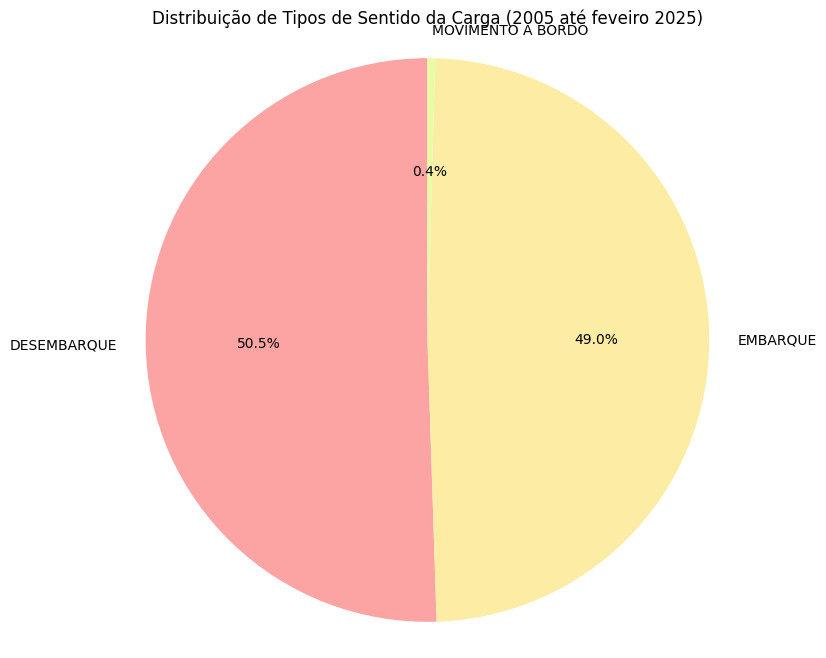

In [ ]:
cores = {
    'DESEMBARQUE': '#fca4a4',
    'EMBARQUE': '#fceca4',
    'MOVIMENTO A BORDO': '#e8fca4'
}


plt.figure(figsize=(8, 8))
plt.pie(
    resumo_sentido_carga['contagem'],
    labels=resumo_sentido_carga.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[cores[label] for label in resumo_sentido_carga.index]
)
plt.title('Distribuição de Tipos de Sentido da Carga (2005 até feveiro 2025)')
plt.axis('equal')
plt.show()

O gráfico mostra que praticamente metade das operações portuárias corresponde a desembarque, ligeiramente acima de 50 %, enquanto o embarque responde por cerca de 49 %, e o movimento a bordo é praticamente insignificante com apenas 0,4 %, esse equilíbrio quase perfeito entre desembarque e embarque.

# Gráfico Temporal Interativo de Toneladas, TEUs e Unidades

In [ ]:
df['data'] = pd.to_datetime(
    df[['ano', 'mês']].assign(day=1).rename(columns={'ano':'year','mês':'month'})
)
ts = (
    df
    .groupby('data')[['toneladas','teus','unidades']]
    .sum()
    .reset_index()
)
ts['year']  = ts['data'].dt.year
ts['month'] = ts['data'].dt.month

app = dash.Dash(__name__)

year_opts   = [{'label':'Todos','value':'All'}] + [{'label': y, 'value': y} for y in sorted(ts['year'].unique())]
month_opts  = [{'label':'Todos','value':'All'}] + [{'label': m, 'value': m} for m in range(1,13)]
metric_opts = [{'label':'Todas','value':'All'}] + [
    {'label':'Toneladas','value':'toneladas'},
    {'label':'TEUs','value':'teus'},
    {'label':'Unidades','value':'unidades'}
]

app.layout = html.Div([
    html.Div([
        html.Label("Ano:"),
        dcc.Dropdown(
            id='year-dropdown',
            options=year_opts,
            value='All'
        ),
    ], style={'width':'30%', 'display':'inline-block'}),
    html.Div([
        html.Label("Mês:"),
        dcc.Dropdown(
            id='month-dropdown',
            options=month_opts,
            value='All'
        ),
    ], style={'width':'30%', 'display':'inline-block', 'marginLeft':'2%'}),
    html.Div([
        html.Label("Métrica:"),
        dcc.Dropdown(
            id='metric-dropdown',
            options=metric_opts,
            value='All'
        ),
    ], style={'width':'30%', 'display':'inline-block', 'marginLeft':'2%'}),
    dcc.Graph(id='time-series-graph')
])

@app.callback(
    Output('time-series-graph', 'figure'),
    [
        Input('year-dropdown', 'value'),
        Input('month-dropdown','value'),
        Input('metric-dropdown','value')
    ]
)
def update_figure(selected_year, selected_month, selected_metric):
    dff = ts.copy()
    title_parts = []

    if selected_year != 'All':
        dff = dff[dff['year'] == int(selected_year)]
        title_parts.append(f"{selected_year}")
    else:
        title_parts.append("Todos os Anos")


    if selected_month != 'All':
        dff = dff[dff['month'] == int(selected_month)]
        title_parts.append(f"Mês {int(selected_month):02d}")
    else:
        title_parts.append("Todos os Meses")


    if selected_metric != 'All':
        y_cols = [selected_metric]
        title_metrics = selected_metric.capitalize()
    else:
        y_cols = ['toneladas','teus','unidades']
        title_metrics = "Todas as Métricas"

    title = f"{title_metrics} — {' | '.join(title_parts)}"

    fig = px.line(
        dff,
        x='data',
        y=y_cols,
        labels={'data':'Data', 'value':'Volume', 'variable':'Métrica'},
        title=title
    )

    fig.update_xaxes(
        dtick="M1",
        tickformat="%Y\n%b"
    )
    fig.update_yaxes(separatethousands=True)
    fig.update_layout(legend_title_text='Métrica')

    return fig

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

# Resumo Anual:  Soma, Média e Desvio Padrão de Toneladas, TEUs e Unidades

In [ ]:
df['data'] = pd.to_datetime({
    'year':  df['ano'],
    'month': df['mês'],
    'day':   1
})

df['year'] = df['data'].dt.year

resumo_est_por_ano = (
    df
    .groupby('year')
    .agg(
        toneladas_sum   = ('toneladas', 'sum'),
        toneladas_mean  = ('toneladas', 'mean'),
        toneladas_std   = ('toneladas', 'std'),
        teus_sum        = ('teus',      'sum'),
        teus_mean       = ('teus',      'mean'),
        teus_std        = ('teus',      'std'),
        unidades_sum    = ('unidades',  'sum'),
        unidades_mean   = ('unidades',  'mean'),
        unidades_std    = ('unidades',  'std')
    )
    .reset_index()
)

display(resumo_est_por_ano)

,year,toneladas_sum,toneladas_mean,toneladas_std,teus_sum,teus_mean,teus_std,unidades_sum,unidades_mean,unidades_std
0,2005,1747433.642,131.336613,210.971121,2260290,169.882751,746.880511,40431498,3038.819842,52855.749374
1,2006,1858101.990,136.444558,217.033843,2340784,171.888970,725.666757,37450452,2750.069907,49045.804034
2,2007,1663260.109,133.573732,213.637127,2558516,205.470286,861.294910,35776632,2873.163508,47076.623389
3,2008,1850041.380,139.268397,214.163626,2710446,204.038392,870.396039,26621050,2003.993526,37670.962351
4,2009,1589688.634,129.306054,207.279925,2256785,183.568001,758.067166,32830016,2670.409631,39571.742078
5,2010,1681172.468,129.930634,208.747661,2739718,211.741093,931.335848,25634058,1981.146766,31358.984497
6,2011,2010950.716,142.914556,219.950154,2991485,212.599318,969.661603,18580238,1320.463222,25512.462366
7,2012,1893135.230,141.829130,217.200707,3175406,237.893767,1046.806397,13433460,1006.402457,22400.635315
8,2013,1811519.112,138.305017,216.017586,3458975,264.084211,1137.142348,16656753,1271.702016,26437.383484
9,2014,2149409.921,146.707387,224.202556,3685658,251.563579,953.126851,8829964,602.686779,10596.735747


Na análise dos dados de 2005 a 2025 percebe-se um crescimento progressivo no volume total de toneladas movimentadas, saltando de cerca de 1,75 milhão de toneladas em 2005 para aproximadamente 2,44 milhões de toneladas em 2024, e caindo abruptamente para 385 mil toneladas em 2025 (parcial, até fevereiro). Esse movimento reflete tanto a tendência de expansão dos terminais até o pico recente quanto a limitação de amostragem no início de 2025. O desvio‐padrão de toneladas também aumenta ao longo do período, passando de cerca de 210 t em 2005 para 230 t em 2025, o que indica maior variabilidade e heterogeneidade nos volumes processados pelos diferentes terminais ao longo dos anos.

Em relação aos TEUs (Twenty-foot Equivalent Units), a soma anual sobe de 2,26 milhões de TEUs em 2005 para 5,49 milhões de TEUs em 2024, demonstrando um foco crescente em cargas conteinerizadas. Em 2025, o total parcial é de 895 mil TEUs até fevereiro. O desvio‐padrão de TEUs passa de aproximadamente 747 TEUs em 2005 para 1.448 TEUs em 2025, mostrando que a dispersão dos volumes de TEUs entre diferentes terminais ampliou-se ao longo dos anos, o que reflete tanto a diversificação das cadeias logísticas quanto investimentos em infraestrutura portuária.

As unidades movimentadas (carga fracionada, veículos etc.) acompanham uma trajetória mais oscilante, mas com tendência de alta na última década: saindo de 40,43 milhões de unidades em 2005, caindo até um mínimo de 3,88 milhões em 2016, e depois voltando a crescer para aproximadamente 12,19 milhões em 2024 (com 1,36 milhão em 2025 até fevereiro). O desvio‐padrão para unidades aumenta de 52.856 em 2005 para 4.469 em 2025 (parcial), mas ao longo do período apresenta picos de dispersão em anos como 2005 (σ ≈ 52.856), 2021 (σ ≈ 14.532) e 2023 (σ ≈ 26.248), indicando que, em determinados anos, houve terminais muito mais ativos que dispararam acima da média, gerando maior assimetria na carga de trabalho.

Nos anos de crise, como 2009, a soma de toneladas recua para 1,59 milhão e os TEUs para 2,26 milhões, com desvio‐padrão de toneladas em torno de 207 t e de TEUs em 758 TEUs, sinalizando menor atividade agregada e menos dispersão entre terminais. Já no período de 2020 a 2022, apesar das incertezas da pandemia, registra-se soma anual acima de 2,13–2,30 milhões de toneladas e mais de 4,23–4,98 milhões de TEUs, pontuando a resiliência e retomada do setor; nesses anos também se observam valores máximos de desvio‐padrão (por volta de 224 t para toneladas e 1.164 TEUs para conteinerizados), o que mostra alta variação entre diferentes terminais. Em 2013, havendo uma queda notável da soma de toneladas para 1,81 milhão (com desvio‐padrão de 216 t), percebemos que, mesmo com o volume médio anual mais baixo, alguns terminais registraram picos de movimentação (aumentando a dispersão). Nos anos subsequentes, a média de toneladas volta a subir gradativamente até atingir novos recordes em 2024, demonstrando a trajetória de recuperação e crescimento contínuo das operações portuárias brasileiras ao longo das duas últimas décadas.

# Boxplots de Total Anual de Toneladas por Intervalo de 5 Anos

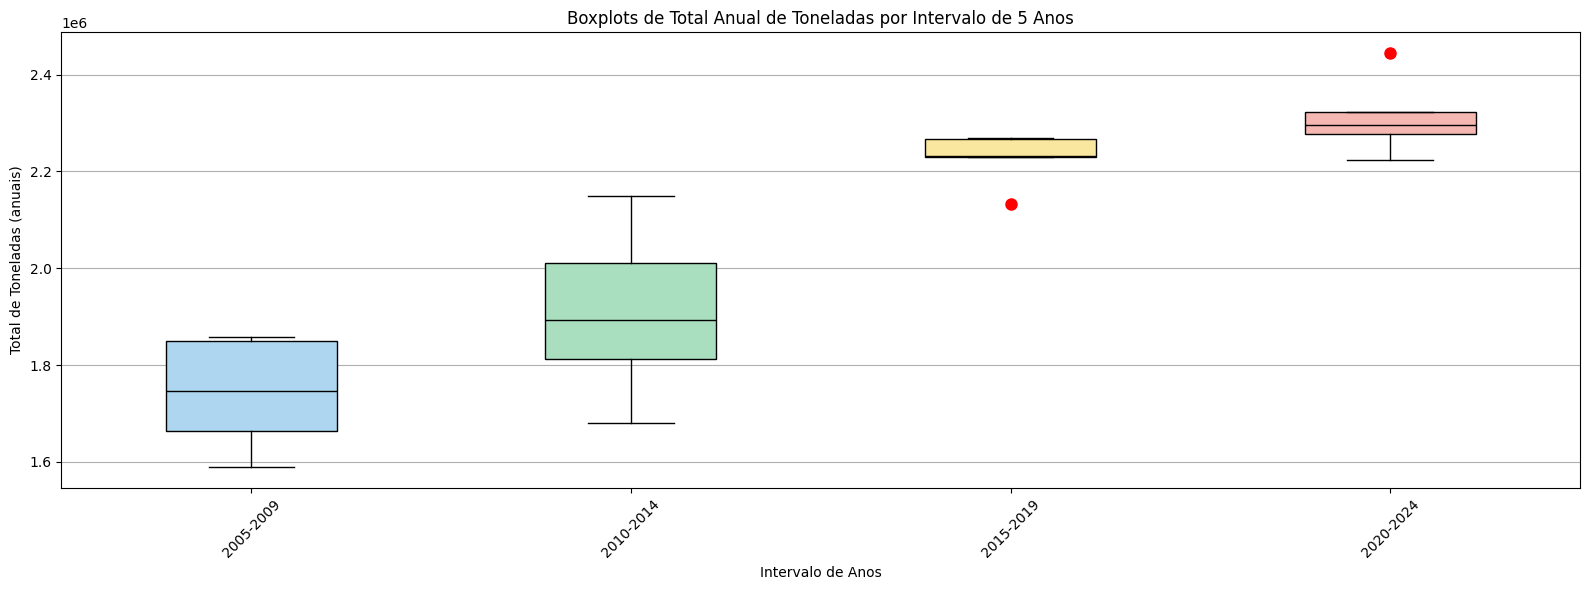

In [ ]:
toneladas_por_ano = (
    df
    .groupby('year')['toneladas']
    .sum()
    .reset_index()
)

bins = list(range(2005, 2030, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

toneladas_por_ano['intervalo_5a'] = pd.cut(
    toneladas_por_ano['year'],
    bins=bins,
    labels=labels,
    right=False
)

data_por_intervalo = [
    toneladas_por_ano.loc[toneladas_por_ano['intervalo_5a'] == label, 'toneladas']
    for label in labels
]


cores = ['#AED6F1', '#A9DFBF', '#F9E79F', '#F5B7B1']


flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=8,
    linestyle='none'
)


plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_por_intervalo,
    tick_labels=labels,
    patch_artist=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

plt.xticks(rotation=45)
plt.xlabel('Intervalo de Anos')
plt.ylabel('Total de Toneladas (anuais)')
plt.title('Boxplots de Total Anual de Toneladas por Intervalo de 5 Anos')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


Observando-se os boxplots, já se nota um deslocamento contínuo da distribuição para valores mais elevados ao longo do tempo. No período de 2005 a 2009, a linha que define a mediana encontra-se em torno de 1,75 milhão de toneladas, e a caixa que corresponde ao intervalo interquartílico (IQR) estende-se de aproximadamente 1,65 milhão a 1,85 milhão. À medida que avançamos para 2010–2014, vê-se que a mediana sobe para perto de 1,90 milhão, com o IQR deslocando-se para algo entre 1,80 milhão e 2,01 milhões. Nesse primeiro comparativo, fica claro que houve aumento geral nos volumes totais anuais movimentados.

No boxplot de 2015–2019, a mediana avança ainda mais, situando-se por volta de 2,25 milhões de toneladas anuais. A extensão da caixa, que vai de aproximadamente 2,23 milhões a 2,27 milhões, revela um estreitamento relativo do IQR em comparação aos períodos anteriores, indicando que a maior parte dos anos desse intervalo concentrou-se em valores mais próximos uns dos outros. A presença de um ponto isolado abaixo do limite do limite inferior (por volta de 2,13 milhões) sinaliza um ano atípico com tonagem inferior ao esperado para aquele intervalo, o que pode estar associado a fatores específicos que seram mais estudados após essa análise.

Ao analisar o intervalo de 2020 a 2024, percebe-se que a mediana encontra-se em torno de 2,30 milhões de toneladas, com o IQR variando de cerca de 2,28 milhões a 2,32 milhões. Essa estabilidade reforça que o patamar de movimentação anual dos terminais atingiu um novo nível, ligeiramente superior ao do intervalo anterior (2015-2019). Ainda assim, há um ponto destacado acima do limite superior, próximo a 2,45 milhões de toneladas, que constitui um outlier de alto volume para esse período. Esse pico pode refletir um ano de recuperação econômica intensa ou de aumento excepcional na demanda logística, possivelmente apontando para mudanças pontuais nos fluxos de comércio, também será estudado após o fim dessa análise.

Ao comparar os quatro boxplots de forma continuada, a tendência evidente é de crescimento contínuo do volume agregado movimentado anualmente, acompanhado de um estreitamento gradual do IQR nos últimos anos. Isso sugere que as operações portuárias evoluíram para patamares mais robustos e, ao mesmo tempo, mais consistentes entre si, diminuindo a dispersão dos resultados anuais.

Esses outliers podem distorcer a formação dos clusters, por isso iremos analisá-los mais profundamente a fim de encontrar a melhor abordagem para tratá-los.

In [ ]:
#função para encontrar os outliers
def encontrar_outliers_por_intervalo(grupo: pd.DataFrame, coluna: str) -> pd.DataFrame:

    valores = grupo[coluna]

    Q1 = valores.quantile(0.25)
    Q3 = valores.quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    mask_outlier = (valores < limite_inferior) | (valores > limite_superior)

    return grupo.loc[mask_outlier]

**Encontrando os outliers do gráfico acima**

In [ ]:
outliers_toneladas = (
    toneladas_por_ano
    .groupby('intervalo_5a', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='toneladas'))
)

print("Outliers de toneladas por intervalo de 5 anos:")
display(outliers_toneladas[['intervalo_5a', 'year', 'toneladas']])

Outliers de toneladas por intervalo de 5 anos:


<ipython-input-129-e4f3eca09292>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-129-e4f3eca09292>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,intervalo_5a,year,toneladas
11,2015-2019,2016,2133388.028
19,2020-2024,2024,2444370.636


- **Outlier inferior do boxplot de 2015-2019**

No ano de 2016, o Porto de Santos registrou um movimento total de 113,815 milhões de toneladas, o que representou uma queda de 5,1 % em relação a 2015 (119,931 milhões de toneladas) e fez com que aquele ano figurasse como o terceiro menor do quinquênio 2015–2019, tornando-o o outlier inferior no intervalo. Esse desempenho decorreu principalmente de uma redução expressiva nos embarques de milho (queda de 49,7 % em relação a 2015) e de operações de carga conteinerizada mais fracas, ambas afetadas por fatores conjunturais como a valorização do real, que prejudicou a competitividade das exportações de maior valor agregado em um cenário global de demanda ainda contida. Como consequência, embora ainda estivesse entre os maiores volumes já atingidos, o total anual de toneladas ficou abaixo da média dos anos vizinhos e apareceu isolado como valor atípico no boxplot para 2016

fonte: [Porto de Santos atinge em 2016 seu terceiro maior movimento anual](https://cnabrasil.org.br/noticias/porto-de-santos-atinge-em-2016-seu-terceiro-maior-movimento-anual?)


- **Outlier Superior do boxplot de 2020-2024**

Já em 2024, o Porto de Santos bateu seu recorde histórico de movimentação de cargas, alcançando 179,8 milhões de toneladas entre janeiro e dezembro, um avanço de 3,8 % em relação a 2023 e consolidando o maior resultado anual da história do complexo portuário. Esse salto foi impulsionado tanto pelo segmento de contêineres, que ultrapassou pela primeira vez a marca de 5 milhões de TEU (fechando o ano com 5,4 milhões de TEU, alta de 14,7 %), quanto pelo agronegócio, com destaque para o açúcar (27,0 milhões de toneladas, +17,8 %), soja em grãos (27,8 milhões) e milho (15,9 milhões), além de granéis líquidos e carga geral solta. A combinação de investimentos em infraestrutura, melhorias operacionais e recuperação de preços de commodities fez com que 2024 surgisse como o outlier superior no quinquênio 2020–2024, figura que se refletiu diretamente no boxplot com o pico de 2 444 370,636 toneladas naquele ano.

fonte: [Porto de Santos bate recorde histórico de movimentação de cargas em 2024](https://agenciaporto.com/noticias/porto-de-santos-bate-recorde-historico-de-movimentacao-de-cargas-em-2024?)

Conforme visto acima, os outliers ocorreram devido a eventos reais, e não por erros na base de dados, então excluí-los não seria adequado.

# Boxplots do Total Anual de Teus por Intervalo de 5 Anos

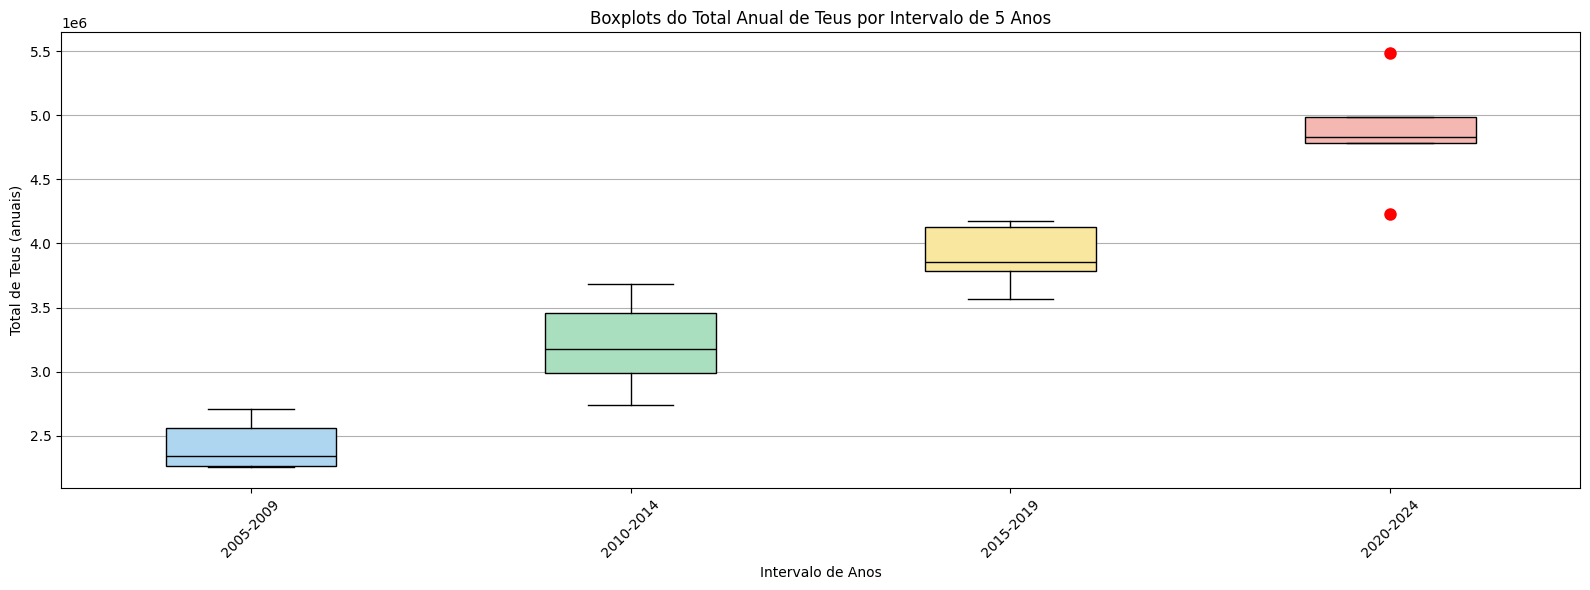

In [ ]:
teus_por_ano = (
    df
    .groupby('year')['teus']
    .sum()
    .reset_index()
)

bins = list(range(2005, 2030, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

teus_por_ano['intervalo_5a'] = pd.cut(
    teus_por_ano['year'],
    bins=bins,
    labels=labels,
    right=False
)

data_por_intervalo = [
    teus_por_ano.loc[teus_por_ano['intervalo_5a'] == label, 'teus']
    for label in labels
]


cores = ['#AED6F1', '#A9DFBF', '#F9E79F', '#F5B7B1']


flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=8,
    linestyle='none'
)


plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_por_intervalo,
    tick_labels=labels,
    patch_artist=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

plt.xticks(rotation=45)
plt.xlabel('Intervalo de Anos')
plt.ylabel('Total de Teus (anuais)')
plt.title('Boxplots do Total Anual de Teus por Intervalo de 5 Anos')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Observando os boxplots vemos que no período inicial, a caixa referente a 2005–2009 está posicionada com valores de quartis entre aproximadamente 2,27 e 2,55 milhões de TEUs, com a mediana situando-se perto de 2,34 milhões, e os limites estendendo-se de cerca de 2,25 a 2,70 milhões. Essa distribuição relativamente compacta indica que, na primeira metade dos anos 2000, a maioria dos terminais mantinha volumes anuais de contêineres em faixas similares, sem grandes oscilações extremas.

Já em 2010–2014, observa-se avanço considerável tanto na mediana, que se aproxima de 3,18 milhões de TEUs, quanto na amplitude do intervalo interquartío, que passa a abranger de cerca de 2,95 a 3,45 milhões. Nesse intervalo, os limites vão de aproximadamente 2,75 a 3,70 milhões, sugerindo aumento da variabilidade entre os anos ainda que sem presença de outliers. Esse crescimento reflete a expansão da atividade conteinerizada, com terminais obedecendo a padrões mais elevados de movimentação, embora ainda relativamente homogêneos dentro desse intervalo (2010-2014).

No intervalo de 2015 a 2019, a caixa situa-se entre cerca de 3,78 e 4,13 milhões de TEUs, com mediana em torno de 3,85 milhões, e os bigodes se estendem de aproximadamente 3,57 a 4,17 milhões. Essa progressão confirma a tendência contínua de incremento de mais contêineres. Além disso, a caixa de 2015–2019 é visualmente mais alta que as anteriores, mas apresenta um estreitamento relativo em comparação a 2010–2014, indicando que os anos desse período, ainda que mais volumosos, tiveram uma dispersão interna ligeiramente menor ou seja, o desempenho anual se manteve mais consistente em torno da nova mediana elevada.

Ao analisar o intervalo mais recente, 2020–2024, nota-se que o IQR desloca-se para aproximadamente 4,80 a 4,98 milhões de TEUs, enquanto a mediana se posiciona perto de 4,85 milhões. Os limites vão de cerca de 4,78 até quase 4,995 milhões, mostrando que o patamar de movimentação anual desses anos alcançou um novo nível. Entretanto, o que se destaca nesse intervalo é o surgimento de dois outliers, um inferior de 4,30 milhões, indicando um ano atipicamente baixo em comparação ao restante do grupo, e outro acima de 5,50 milhões, representando um ano de desempenho bastante elevado, em termos de evolução histórica, os boxplots revelam que, de 2005 até 2024, houve um aumento constante e significativo na movimentação total anual de TEUs, com cada intervalo superando o anterior em termos de medianas e dos quartis superiores. A variabilidade interna aos grupos também tende a crescer até 2014, depois estabiliza ligeiramente em 2015–2019 e permanece alta em 2020–2024, embora o grupo mais recente tenha apresentando os valores mais homogêneos em torno de uma mediana mais alta.

**Encontrando os outliers do gráfico acima**

In [ ]:
outliers_teus = (
    teus_por_ano
    .groupby('intervalo_5a', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='teus'))
)

print("Outliers de teus por intervalo de 5 anos:")
display(outliers_teus[['intervalo_5a', 'year', 'teus']])

Outliers de teus por intervalo de 5 anos:


<ipython-input-131-6fc2087704e4>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-131-6fc2087704e4>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,intervalo_5a,year,teus
15,2020-2024,2020,4233438
19,2020-2024,2024,5486039


- **Outlier inferior do boxplot de 2020-2024**

Em 2020, o Porto de Santos sofreu forte impacto inicial da pandemia de COVID-19, sobretudo no primeiro semestre, quando as medidas de isolamento social e a redução da atividade econômica global provocaram queda nos volumes de contêineres. Mesmo assim, ao longo do ano, houve recuperação progressiva: o agregado anual de TEUs movimentados em 2020 foi de 4,23 milhões, um ligeiro aumento (1,6 %) em relação ao recorde anterior de 2019 (4,17 milhões). Esse valor, contudo, configura-se como outlier inferior no intervalo 2020–2024, já que nos anos seguintes a movimentação de TEUs retomou a trajetória de crescimento expressivo.

fonte: [Porto de Santos: Contêiner se recupera e fecha dezembro de 2020 com alta de 20%, recorde histórico](https://www.portodesantos.com.br/2021/01/28/porto-de-santos-conteiner-se-recupera-e-fecha-em-dezembro-de-2020-com-alta-de-20-recorde-historico)

- **Outlier superior do boxplot de 2020-2024**

Em 2024, o Porto de Santos novamente estipulou um marco histórico para o segmento de contêineres, ultrapassando 5 milhões de TEUs pela primeira vez e fechando o ano com aproximadamente 5,4 milhões de TEUs movimentados (crescimento de 14,7 % em relação a 2023). Esse desempenho recorde, impulsionado por maior demanda do agronegócio, avanços logísticos e investimentos em infraestrutura, faz de 2024 o outlier superior no período 2020–2024, com valor de 5 486 039 TEUs no nosso conjunto de dados.

fonte: [Porto de Santos bate recorde histórico de movimentação de cargas em 2024](https://www.portodesantos.com.br/2025/01/16/porto-de-santos-bate-recorde-historico-de-movimentacao-de-cargas-em-2024)

Novamente os outliers ocorreram devido a eventos reais, e não por erros na base de dados, então excluí-los não seria adequado.



# Boxplots do Total Anual de Unidades por Intervalo de 5 Anos

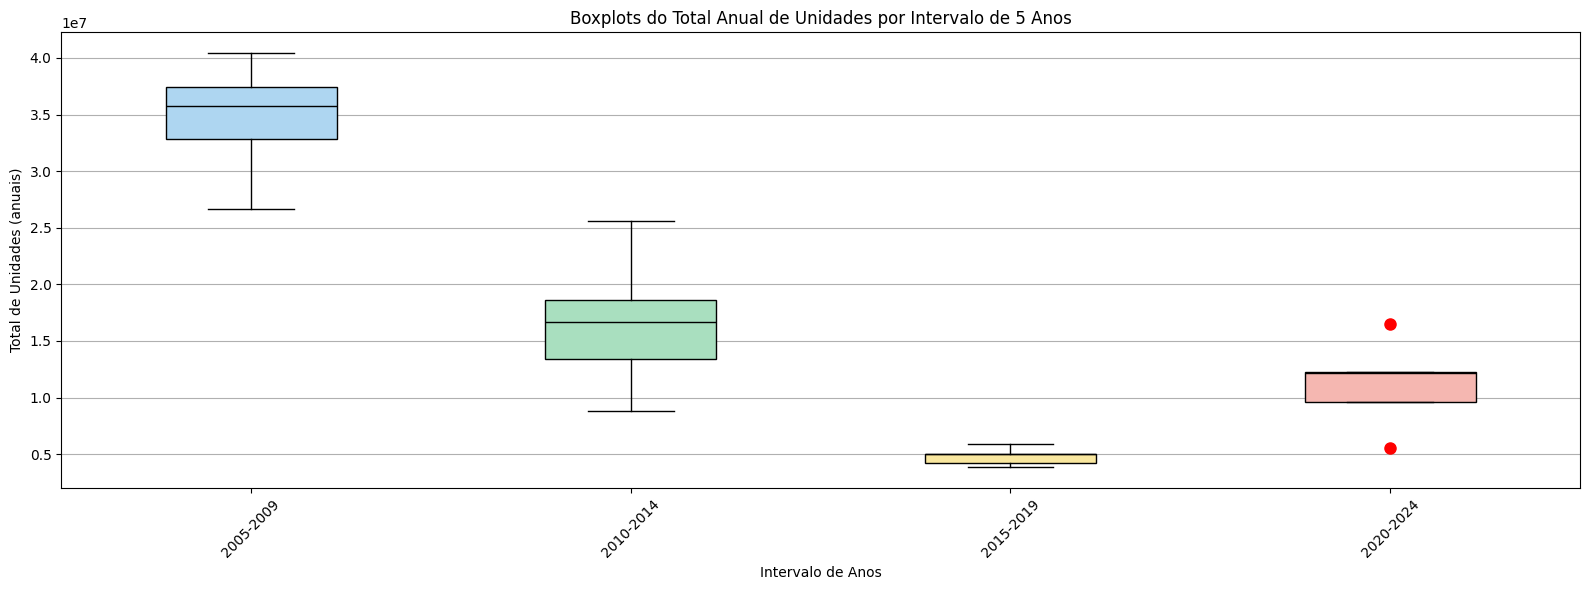

In [ ]:
unidades_por_ano = (
    df
    .groupby('year')['unidades']
    .sum()
    .reset_index()
)

bins = list(range(2005, 2030, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

unidades_por_ano['intervalo_5a'] = pd.cut(
    unidades_por_ano['year'],
    bins=bins,
    labels=labels,
    right=False
)

data_por_intervalo = [
    unidades_por_ano.loc[unidades_por_ano['intervalo_5a'] == label, 'unidades']
    for label in labels
]


cores = ['#AED6F1', '#A9DFBF', '#F9E79F', '#F5B7B1']


flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=8,
    linestyle='none'
)


plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_por_intervalo,
    tick_labels=labels,
    patch_artist=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

plt.xticks(rotation=45)
plt.xlabel('Intervalo de Anos')
plt.ylabel('Total de Unidades (anuais)')
plt.title('Boxplots do Total Anual de Unidades por Intervalo de 5 Anos')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Observando-se o boxplot referente ao total anual de unidades movimentadas pelos terminais em cada intervalo de cinco anos, percebe-se que, no intervalo de 2005 a 2009, a mediana situa-se em torno de 35 milhões de unidades, com o primeiro quartil próximo de 32 milhões e o terceiro quartil em torno de 37 milhões. Os limites estendem-se desde aproximadamente 26,5 milhões até pouco mais de 40 milhões de unidades, indicando que, embora a maior parte dos anos desse período esteja concentrada entre 32 e 37 milhões, houve oscilações mais amplas que alcançaram tanto patamares significativamente menores como valores picos que superaram 40 milhões.

Avançando para 2010–2014, nota-se uma drástica redução no total de unidades, a mediana cai para aproximadamente 16 milhões, enquanto o IQR se posiciona entre cerca de 13 milhões (primeiro quartil) e 18 milhões (terceiro quartil). Os limites, por sua vez, alcançam valores mínimos em torno de 8,8 milhões e máximos próximos de 25,5 milhões. Essa divergência ampla sugere que, nesse intervalo, alguns anos tiveram um volume de unidades movimentadas bem abaixo do patamar médio para o período, contrastando fortemente com o pico observado nos anos mais produtivos, o que resulta em uma distribuição significativamente mais dispersa do que no intervalo anterior de 2005-2009.

No período de 2015–2019, a queda atinge seus valores mais baixos, com a mediana posicionada em torno de 4,7 milhões de unidades. O intervalo interquartío fica entre aproximadamente 4,4 e 5,1 milhões, e os limites variam de cerca de 3,7 até quase 5,9 milhões. A dispersão interna é relativamente menor do que em 2010–2014, sinalizando que os anos desse intervalo, ainda que com volumes muito inferiores aos observados inicialmente, apresentaram um grau de consistência maior entre si, concentrando-se mais próximos da mediana ao redor de 4,7 milhões e sem a presença de verdadeiros outliers extremos dentro dos limites.

Já em 2020–2024, verifica-se uma retomada parcial, com a mediana encontrando-se por volta de 9,9 milhões de unidades e o IQR variando de cerca de 9,6 a 12,2 milhões. Os limites, estendendo-se de aproximadamente 9,5 a 12,3 milhões, mostram que a maior parte dos anos segue esse padrão de retomada, mas surgem dois outliers um valor inferior abaixo de 5,5 milhões, indicando um ano bem fraco em comparação ao restante do grupo, e outro acima de 16,5 milhões, apontando para um período de recuperação ou aumento súbito de atividade. Esses outliers refletem anos de grande volatilidade, possivelmente associados a eventos externos.

Em termos de tendência geral, percebe-se que houve um declínio acentuado no total anual de unidades desde o pico de 2005–2009 até a queda em 2015–2019, seguido por uma recuperação nos anos mais recentes, ainda que sem retornar aos valores originais do primeiro intervalo. A dispersão interna, inicialmente ampla em 2005–2009, diminuiu parcialmente em 2010–2014, atingiu o menor patamar de variabilidade em 2015–2019 e aumentou novamente em 2020–2024 devido aos outliers.

Essa declínio aparenta ser mais por uma mudança de metodologia do que uma real redução, basicamente uma mudança na forma de contabilização, com a adoção crescente de contêineres como unidade de medida, Entre meados dos anos 2000 e 2014, houve forte migração de carga geral “unitizada” (que antigamente vinha em caixas, fardos, latas, sacas etc.) para contêineres. Na prática, mercadorias que antes eram contabilizadas pela quantidade de caixas/fardos começaram a ser registradas quase que exclusivamente em TEUs (os 20-pés).

[A MOVIMENTAÇÃO DE CARGAS NOS PORTOS BRASILEIROS](https://1library.org/article/a-movimentação-de-cargas-nos-portos-brasileiros.zw5kep1z?)



**Encontrando os outliers do gráfico acima**

In [ ]:
outliers_unidades = (
    unidades_por_ano
    .groupby('intervalo_5a', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='unidades'))
)

print("Outliers de unidades por intervalo de 5 anos:")
display(outliers_unidades[['intervalo_5a', 'year', 'unidades']])

Outliers de unidades por intervalo de 5 anos:


<ipython-input-133-e5b24de846cf>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-133-e5b24de846cf>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,intervalo_5a,year,unidades
15,2020-2024,2020,5549589
18,2020-2024,2023,16500241


- **Outlier inferior do boxplot de 2020-2024**

Em 2020, o Porto de Santos enfrentou desafios significativos devido à pandemia de COVID-19, que impactou a movimentação de cargas. Apesar disso, o porto registrou um crescimento de 7,7% em comparação com 2019, atingindo 114,4 milhões de toneladas movimentadas. Esse aumento foi impulsionado principalmente pela alta na exportação de açúcar, que cresceu 82,7%, e pela soja, com um incremento de 28,6% . No entanto, a movimentação de contêineres foi afetada, refletindo uma redução no número de unidades movimentadas, o que contribuiu para que 2020 fosse identificado como um outlier inferior no intervalo de 2020–2024.

[Movimentação portuária cresce 4,2% em 2020](https://www.gov.br/antaq/pt-br/noticias/2021/movimentacao-portuaria-cresce-4-2-em-2020?)


Em contraste, 2023 marcou um ano de recuperação e crescimento para o Porto de Santos. O porto atingiu a marca histórica de 173,3 milhões de toneladas movimentadas, representando um aumento de 6,7% em relação a 2022. Esse crescimento foi impulsionado por uma safra recorde de grãos e cana-de-açúcar, além da recuperação na movimentação de contêineres, que registrou um aumento de 15,5% em TEUs no último mês do ano . Esses fatores contribuíram para que 2023 fosse identificado como um outlier superior no mesmo intervalo.

[Porto de Santos Alcança Novo Recorde com 173,3 Milhões de Toneladas Movimentadas em 2023](https://seger.com.br/porto-de-santos-alcanca-novo-recorde-com-1733-milhoes-de-toneladas-movimentadas-em-2023)




Todos os outliers identificados resultam de eventos reais, e não de erros na base de dados, tanto em toneladas, TEUs quanto em unidades. É importante destacar que, na maioria dos casos, esses valores extremos ocorrem apenas nos boxplots do intervalo de 2020 a 2024. Como se tratam de dados válidos, ainda que atípicos, optamos por uma padronização com escalonamento robusto (RobustScaler), que é mais apropriada para lidar com outliers sem distorcer a estrutura dos dados. Essa abordagem visa preservar a integridade das informações e garantir um melhor desempenho dos modelos de agrupamento.

# Boxplot de Toneladas Anuais por Terminal (Top 5) — 2005 até Dezembro/2024

<ipython-input-134-a2d2a6214ddf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-134-a2d2a6214ddf>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



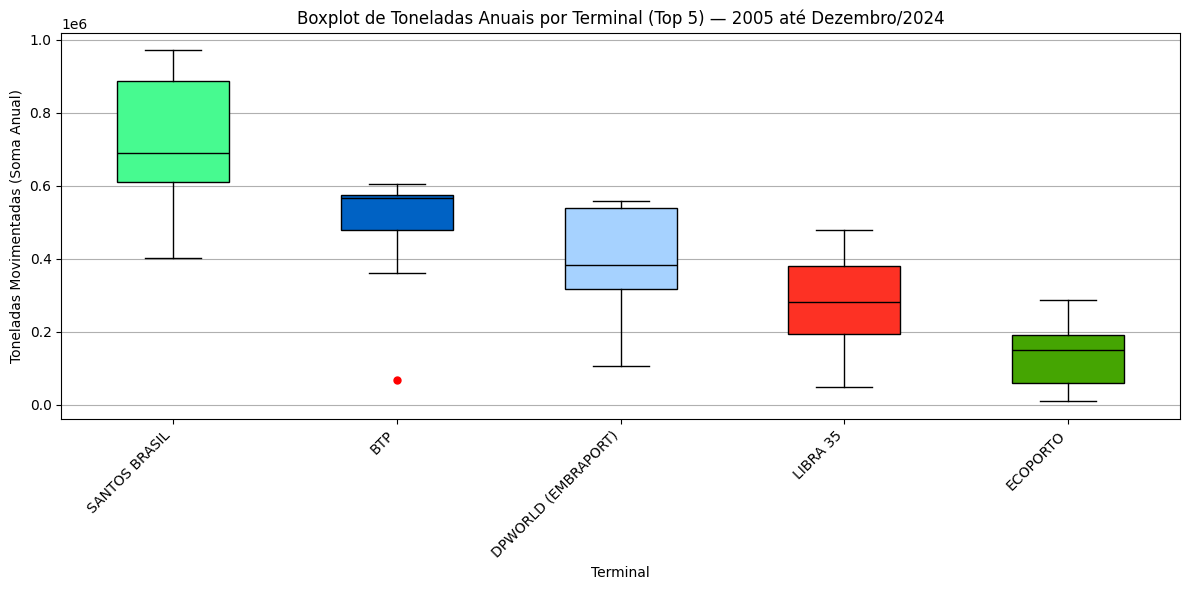

In [ ]:
df_top5['data'] = pd.to_datetime({
    'year':  df_top5['ano'],
    'month': df_top5['mês'],
    'day':   1
})
df_top5['year'] = df_top5['data'].dt.year
df_top5 = df_top5[df_top5['year'] <= 2024]
toneladas_por_ano_top5 = (
    df_top5
    .groupby(['terminal - gerin', 'year'])['toneladas']
    .sum()
    .reset_index()
)

data_por_terminal = []
for terminal in top5:

    serie_anual = toneladas_por_ano_top5.loc[
        toneladas_por_ano_top5['terminal - gerin'] == terminal,
        'toneladas'
    ]

    data_por_terminal.append(serie_anual.values)


cores = ['#47fa90', '#0062c4', '#a6d2ff', '#fd3124', '#45a502']

flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=5,
    linestyle='none'
)


plt.figure(figsize=(12, 6))

bp = plt.boxplot(
    data_por_terminal,
    tick_labels=top5,
    patch_artist=True,
    showfliers=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set_color('black')
for whisker in bp['whiskers']:
    whisker.set_color('black')
for cap in bp['caps']:
    cap.set_color('black')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Terminal')
plt.ylabel('Toneladas Movimentadas (Soma Anual)')
plt.title('Boxplot de Toneladas Anuais por Terminal (Top 5) — 2005 até Dezembro/2024')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Analisando os boxplots percebe‐se que Santos Brasil apresenta a maior mediana de movimentação, com valores concentrados em torno de 600 a 800 mil toneladas, enquanto o intervalo interquartil é mais estreito nos anos intermediários e mais alargado nos piores e melhores anos, indicando certa consistência com picos de alta e baixa intensidade em fenômenos específicos.

Para BTP observa‐se uma distribuição menos ampla que Santos Brasil, da para ver isso apenas pelo formato da caixa, com mediana próxima a 550 mil toneladas, embora haja um outlier que mostra um ano de movimentação significativamente abaixo da médiana, revelando possível impacto de eventos excepcionais ou variações sazonais extremas para esse terminal.

Na DPWorld (Embraport) a mediana gira em torno de 350 a 400 mil toneladas, mas o intervalo interquartil é bastante alargado, sinalizando grande variabilidade entre os anos em que a movimentação foi baixa e os anos em que foi alta, enquanto o valor mínimo se aproxima de 100 mil toneladas, indicando que houve períodos de atividade mais restrita seguidos de forte retomada que elevou o teto a cerca de 550 mil toneladas.

Libra 35 mostra uma mediana em torno de 250 a 300 mil toneladas, com concentração moderada de dados, mas também exibe níveis próximos de 50 mil toneladas em algum ano atípico de baixa atividade e picos em torno de 480 mil toneladas nos melhores momentos, sugerindo que o terminal passou por fases de expansão e retração significativas, talvez associadas a alterações de contratos e demandas de mercado.

Ecoporto, por fim, apresenta a dispersão mais acentuada entre os cinco, com mediana em torno de 150 mil toneladas e um intervalo interquartil que vai de perto de zero a quase 200 mil toneladas, mostrando que alguns anos praticamente não registraram movimentação significativa, enquanto em outros houve atividade de até 280 mil toneladas, o que indica forte oscilação na operação.

In [ ]:
outliers_toneladas_top5 = (
    toneladas_por_ano_top5
    .groupby('terminal - gerin', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='toneladas'))
)

print("Outliers de toneladas dos top 5 terminais")
display(outliers_toneladas_top5[['terminal - gerin', 'year', 'toneladas']])

Outliers de toneladas dos top 5 terminais


<ipython-input-135-a8d099389bae>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,terminal - gerin,year,toneladas
0,BTP,2013,68414.699


# Boxplot de Teus Anuais por Terminal (Top 5) — 2005 até Dezembro/2024

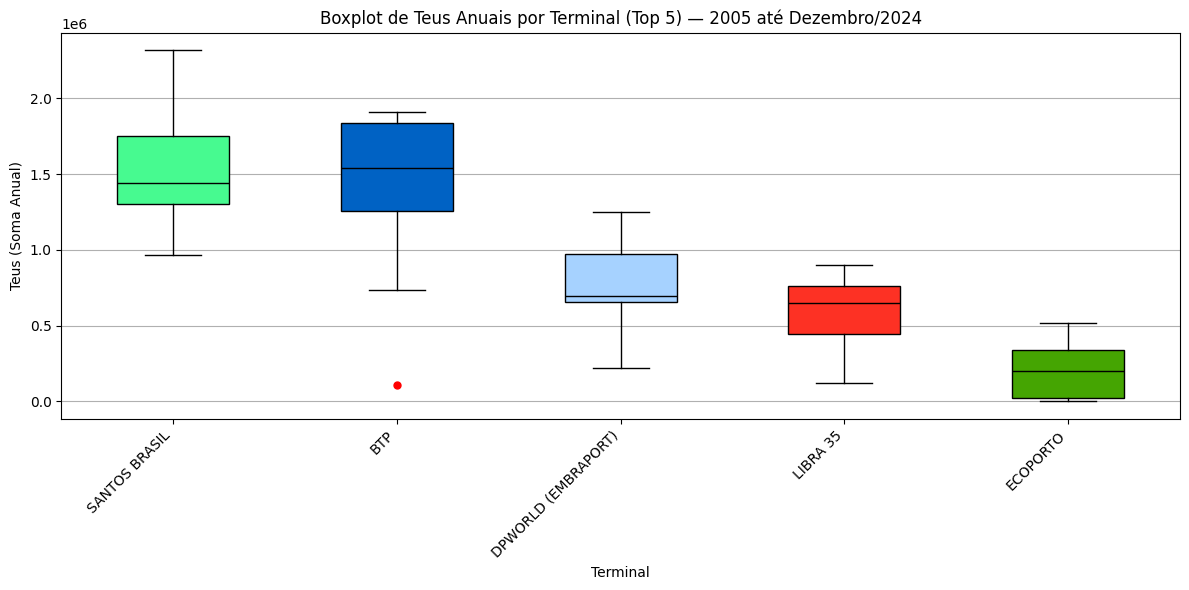

In [ ]:
teus_por_ano_top5 = (
    df_top5
    .groupby(['terminal - gerin', 'year'])['teus']
    .sum()
    .reset_index()
)

data_por_terminal = []
for terminal in top5:

    serie_anual = teus_por_ano_top5.loc[
        teus_por_ano_top5['terminal - gerin'] == terminal,
        'teus'
    ]

    data_por_terminal.append(serie_anual.values)


cores = ['#47fa90', '#0062c4', '#a6d2ff', '#fd3124', '#45a502']

flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=5,
    linestyle='none'
)


plt.figure(figsize=(12, 6))

bp = plt.boxplot(
    data_por_terminal,
    tick_labels=top5,
    patch_artist=True,
    showfliers=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set_color('black')
for whisker in bp['whiskers']:
    whisker.set_color('black')
for cap in bp['caps']:
    cap.set_color('black')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Terminal')
plt.ylabel('Teus (Soma Anual)')
plt.title('Boxplot de Teus Anuais por Terminal (Top 5) — 2005 até Dezembro/2024')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

O primeiro boxplot da Santos Brasil observa-se na mediana valores em torno de 1,4 milhão de TEUs, com whiskers que se estendem de aproximadamente 975 mil até cerca de 2,3 milhões, indicando consistência no alto volume de contêineres, e com limite superior alto, indicando volumes ainda mais altos de contêineres.

Para BTP observa‐se mediana ligeiramente superior a 1,5 milhão de TEUs, com um intervalo interquartil relativamente consistente entre 1,2 milhão e 1,9 milhão, mas há um outlier muito abaixo da média, em torno de 100 mil TEUs, o que sinaliza um ano atípico de baixa atividade que destoou do padrão geral de crescimento e estabilidade do terminal.

Em DPWorld (Embraport) a distribuição apresenta mediana próxima a 700 mil TEUs, com limites que variam de cerca de 200 mil até 1,25 milhão, evidenciando que o terminal teve anos de baixa movimentação seguidos de fortes recuperações, e o longo intervalo interquartil reflete que houve alta volatilidade na operação ao longo do período.

Libra 35 mostra mediana em torno de 650 mil TEUs, com intervalo interquartil que vai de aproximadamente 450 mil até 900 mil, indicando maior estabilidade em relação a DPWorld, mas há registros inferiores a 125 mil e superiores a 1,0 milhão, o que demonstra que esse terminal também enfrentou anos atípicos de retração e picos de crescimento.

Ecoporto exibe a menor mediana entre os cinco, próxima de 200 mil TEUs, com limites que se estendem de valores quase nulos até cerca de 500 mil, revelando que alguns anos praticamente não registraram movimentação significativa e outros alcançaram meio milhão de TEUs, o que evidencia forte oscilação operacional.

In [ ]:
outliers_teus_top5 = (
    teus_por_ano_top5
    .groupby('terminal - gerin', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='teus'))
)

print("Outliers de teus dos top 5 terminais:")
display(outliers_teus_top5[['terminal - gerin', 'year', 'teus']])

Outliers de teus dos top 5 terminais:


<ipython-input-137-e15964b88de8>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,terminal - gerin,year,teus
0,BTP,2013,110155


# Boxplot de Unidades Anuais por Terminal (Top 5) — 2005 até Dezembro/2024

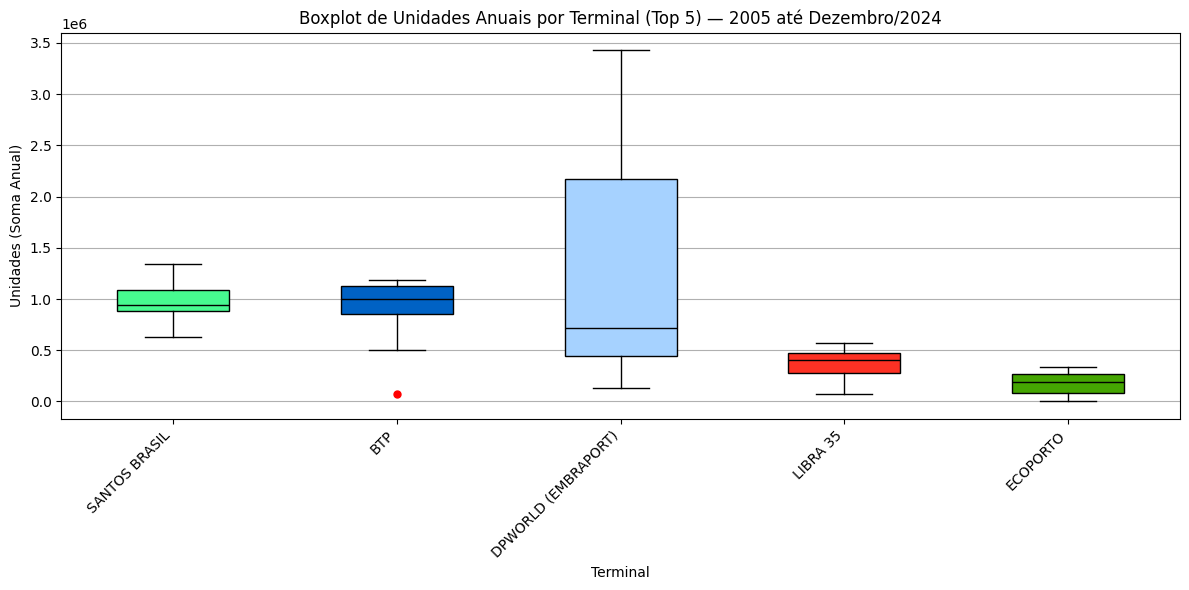

In [ ]:
unidades_por_ano_top5 = (
    df_top5
    .groupby(['terminal - gerin', 'year'])['unidades']
    .sum()
    .reset_index()
)

data_por_terminal = []
for terminal in top5:

    serie_anual = unidades_por_ano_top5.loc[
       unidades_por_ano_top5['terminal - gerin'] == terminal,
        'unidades'
    ]

    data_por_terminal.append(serie_anual.values)


cores = ['#47fa90', '#0062c4', '#a6d2ff', '#fd3124', '#45a502']

flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=5,
    linestyle='none'
)


plt.figure(figsize=(12, 6))

bp = plt.boxplot(
    data_por_terminal,
    tick_labels=top5,
    patch_artist=True,
    showfliers=True,
    flierprops=flierprops,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], cores):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set_color('black')
for whisker in bp['whiskers']:
    whisker.set_color('black')
for cap in bp['caps']:
    cap.set_color('black')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Terminal')
plt.ylabel('Unidades (Soma Anual)')
plt.title('Boxplot de Unidades Anuais por Terminal (Top 5) — 2005 até Dezembro/2024')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Santos Brasil apresenta mediana próxima de 900 000 unidades, com intervalos interquartis que variam de cerca de 850 000 até 1 000 000, o que indica uma operação bastante estável ao longo dos anos, sugerindo consistência no volume de cargas movimentadas por esse terminal.

BTP exibe uma mediana ligeiramente acima de 950 000 unidades e um intervalo interquartil que vai de aproximadamente 800 000 até 1 100 000, mas possui um outlier bem abaixo da média, em torno de 80 000 unidades, sinalizando um ano de baixa excepcional que destoou do padrão de crescimento consistente.

DPWorld (Embraport) mostra a maior variabilidade entre os cinco, com mediana em torno de 700 000 unidades, limites que se estendem de aproximadamente 120 000 até 3 400 000, e um intervalo interquartil muito amplo, refletindo anos de movimentação muito baixa seguidos de picos extraordinários.

Libra 35 apresenta mediana em torno de 350 000 unidades, com intervalo interquartil de cerca de 250 000 até 500 000, indicando certa estabilidade intermediária, mas também mostra limites que vão de 70 000 até 570 000 unidades, revelando que esse terminal passou por anos atípicos de baixa e picos moderados.

Ecoporto exibe a menor mediana, próxima de 200 000 unidades, e um intervalo interquartil que vai de cerca de 50 000 até 300 000, além de limites que atingem quase 330 000, o que evidencia forte oscilação operacional.

In [ ]:
outliers_unidades_top5 = (
    unidades_por_ano_top5
    .groupby('terminal - gerin', group_keys=False)
    .apply(lambda grp: encontrar_outliers_por_intervalo(grp, coluna='unidades'))
)

print("Outliers de unidades dos top 5 terminais:")
display(outliers_unidades_top5[['terminal - gerin', 'year', 'unidades']])

Outliers de unidades dos top 5 terminais:


<ipython-input-139-d24fbb68fe9e>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,terminal - gerin,year,unidades
0,BTP,2013,71324


Os outliers observados nos registros de movimentação de cargas em toneladas, TEUs e unidades no ano de 2013 da BTP, estão diretamente relacionados ao início das operações da Brasil Terminal Portuário (BTP). Esse terminal, localizado na margem direita do Porto de Santos, começou suas atividades comerciais em agosto de 2013, com a atracação do navio MSC Challenger. A inauguração oficial ocorreu em 28 de novembro do mesmo ano.

fontes: [Terminal da BTP é inaugurado oficialmente em Santos](https://www.tecnologistica.com.br/noticias/portos/8212/terminal-da-btp-e-inaugurado-oficialmente-em-santos)

Os dados foram inicialmente organizados a partir do agrupamento por terminal, de modo a extrair o tipo de instalação predominante em cada um, identificando se se tratava de terminal de uso privado. Em seguida, para cada terminal, foram calculadas as proporções relativas de variáveis categóricas relevantes ao fluxo de carga, como a natureza da carga, o tipo de movimento, a via de navegação utilizada e o sentido do carregamento, de forma a transformar contagens brutas em percentuais normalizados por terminal.

Paralelamente, realizou‐se um resumo estatístico das variáveis quantitativas de interesse especificamente toneladas movimentadas, TEUs e unidades  calculando-se a média e o desvio‐padrão para cada terminal. As informações categóricas de proporções e os indicadores numéricos foram então combinados em uma única base de características para cada terminal, fornecendo um conjunto abrangente de atributos que capturam tanto aspectos qualitativos quanto quantitativos das operações portuárias.

Com a base de características consolidada, aplicou‐se um escalonamento robusto aos atributos numéricos com o objetivo de minimizar o impacto de valores extremos visto anteriormente e garantindo que todas as variáveis tivessem escalas comparáveis. Após isso visualizamos gráficamente com um mapa de calor uma matriz de correlação e calculamos o VIF (Variance Inflation Factor) para verificar a se tinha problemas de multicolinearidade devido ao método que utilizamos para criar as proporções, já esperavamos que tivesse esse problema, então resolvemos aplicar o PCA para resolver isso, vimos que 10 componentes já explicavam quase 100% da variância, então fizemos 10 PCs, terminado esse pré‐processamento,partimos para os métodos de agrupamento, foram calculadas as distâncias euclidianas entre os vetores de características escalonadas de cada terminal, estabelecendo a matriz necessária para a comparar diferente métodos de agrupamentos hierárquicos.

Para determinar o método de linkage mais adequado, executaram‐se algoritmos de clustering hierárquico utilizando diferentes formas de cálculo de distância entre clusters e, os métodos testados foram 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward' e para cada método, avaliou‐se o coeficiente cophenético em relação à matriz de distâncias originais. Os resultados foram então comparados em uma tabela, classificando os métodos pelo índice cophenético e indicando aquele que melhor preserva as estruturas de distância no agrupamento hierárquico.

Com base no método de linkage selecionado como melhor para o agrupamento hierárquico, procedeu-se à comparação com o k-means por meio de representações gráficas. Para isso, avaliaram-se três métricas de validação: índice de Silhouette, DBI (Davies-Bouldin Index) e CH (Calinski-Harabasz) considerando variações de 2 a 10 clusters. A seleção do modelo vencedor levou em conta a combinação dos resultados dessas três métricas, garantindo a escolha mais ajustada ao conjunto de dados. Em seguida, esse modelo foi utilizado para determinar, por meio de uma métrica de avaliação, o número ideal de clusters, finalizado esse processo, os agrupamentos foram criados e incorporados ao conjunto de dados original antes do pré‐processamento para a interpretação de cada agrupamento.


In [ ]:
tipo_instalacao_terminal = (
    df.groupby('terminal - gerin')['tipo_instalação (grupos)']
      .agg(lambda x: x.mode()[0])
      .rename('tipo_instalacao_mode')
      .reset_index()
)

tipo_instalacao_terminal['is_privado'] = (
    tipo_instalacao_terminal['tipo_instalacao_mode'] == 'Terminal de Uso Privado'
).astype(int)
tipo_instalacao_terminal = tipo_instalacao_terminal[['terminal - gerin', 'is_privado']]

prop_natureza = (
    df.groupby(['terminal - gerin', 'naturezacarga'])
      .size()
      .unstack(fill_value=0)
)
prop_natureza = (
    prop_natureza
      .divide(prop_natureza.sum(axis=1), axis=0)
      .add_prefix('pct_natureza_')
      .reset_index()
)

prop_movimento = (
    df.groupby(['terminal - gerin', 'tipo_movimento'])
      .size()
      .unstack(fill_value=0)
)
prop_movimento = (
    prop_movimento
      .divide(prop_movimento.sum(axis=1), axis=0)
      .add_prefix('pct_mov_')
      .reset_index()
)

prop_navegacao = (
    df.groupby(['terminal - gerin', 'navegacao'])
      .size()
      .unstack(fill_value=0)
)
prop_navegacao = (
    prop_navegacao
      .divide(prop_navegacao.sum(axis=1), axis=0)
      .add_prefix('pct_nav_')
      .reset_index()
)

prop_sentido = (
    df.groupby(['terminal - gerin', 'sentido_carga'])
      .size()
      .unstack(fill_value=0)
)
prop_sentido = (
    prop_sentido
      .divide(prop_sentido.sum(axis=1), axis=0)
      .add_prefix('pct_sentido_')
      .reset_index()
)


stats_numericos = df.groupby('terminal - gerin').agg({
    'toneladas': ['mean', 'std'],
    'teus': ['mean', 'std'],
    'unidades': ['mean', 'std']
})

stats_numericos.columns = [
    '_'.join(col).strip() for col in stats_numericos.columns.values
]
stats_numericos = stats_numericos.reset_index()

features = (
    tipo_instalacao_terminal
      .merge(prop_natureza, on='terminal - gerin', how='left')
      .merge(prop_movimento, on='terminal - gerin', how='left')
      .merge(prop_navegacao, on='terminal - gerin', how='left')
      .merge(prop_sentido, on='terminal - gerin', how='left')
      .merge(stats_numericos, on='terminal - gerin', how='left')
)

display(features)

,terminal - gerin,is_privado,pct_natureza_CARGA CONTEINERIZADA,pct_natureza_CARGA GERAL,pct_natureza_GRANEL LIQUIDO,pct_natureza_GRANEL SOLIDO,pct_mov_CONTRABORDO,pct_mov_CONVENCIONAL,pct_mov_MALOGRO,pct_mov_REMOÇÃO,...,pct_nav_LONGO CURSO,pct_sentido_DESEMBARQUE,pct_sentido_EMBARQUE,pct_sentido_MOVIMENTO A BORDO,toneladas_mean,toneladas_std,teus_mean,teus_std,unidades_mean,unidades_std
0,ACT (ARM 38),0,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,...,0.984472,0.000000,1.000000,0.000000,45.341652,125.868191,0.000000,0.00000,0.000000,0.000000
1,ADM,0,0.000000,0.001348,0.000000,0.998652,0.0,0.993261,0.000000,0.000000,...,0.962264,0.083558,0.916442,0.000000,132.359904,159.671885,0.000000,0.00000,0.006739,0.183556
2,ADONAI,0,0.000000,0.000000,0.960764,0.039236,0.0,1.000000,0.000000,0.000000,...,0.734889,0.925769,0.074231,0.000000,140.850373,262.562567,0.000000,0.00000,0.000000,0.000000
3,AGEO,0,0.000000,0.000000,0.942154,0.057846,0.0,1.000000,0.000000,0.000000,...,0.585491,0.769575,0.230425,0.000000,91.315426,230.675024,0.000000,0.00000,0.000000,0.000000
4,AGEO LESTE,0,0.000000,0.000000,0.990826,0.009174,0.0,1.000000,0.000000,0.000000,...,0.544954,0.965138,0.034862,0.000000,93.377325,230.053104,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,USIMINAS,0,0.138686,0.519708,0.021898,0.319708,0.0,0.976156,0.000000,0.021898,...,0.812652,0.426764,0.567883,0.005353,67.948520,131.247055,18.109002,130.72038,1293.206813,2465.213176
70,VOPAK (ALAMOA),0,0.000000,0.000000,0.964630,0.035370,0.0,0.999708,0.000292,0.000000,...,0.884829,0.786612,0.213388,0.000000,135.967597,268.599021,0.000000,0.00000,0.000000,0.000000
71,VOPAK (ILHA),0,0.000000,0.000000,0.996633,0.003367,0.0,1.000000,0.000000,0.000000,...,0.470258,0.893378,0.106622,0.000000,185.715786,310.404598,0.000000,0.00000,0.000000,0.000000
72,tec,0,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,177.988000,142.776173,0.000000,0.00000,0.000000,0.000000


In [ ]:
linhas_com_NaN = features[features.isna().any(axis=1)]
display(linhas_com_NaN)

,terminal - gerin,is_privado,pct_natureza_CARGA CONTEINERIZADA,pct_natureza_CARGA GERAL,pct_natureza_GRANEL LIQUIDO,pct_natureza_GRANEL SOLIDO,pct_mov_CONTRABORDO,pct_mov_CONVENCIONAL,pct_mov_MALOGRO,pct_mov_REMOÇÃO,...,pct_nav_LONGO CURSO,pct_sentido_DESEMBARQUE,pct_sentido_EMBARQUE,pct_sentido_MOVIMENTO A BORDO,toneladas_mean,toneladas_std,teus_mean,teus_std,unidades_mean,unidades_std
47,RODRIMAR - ARM VIII,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,4.0,NaN,0.0,NaN,1.0,NaN


Essa linha ficou com toneladas_std,	teus_std,	unidades_std com NaN, talvez pelo valor baixo na média dessas métricas ou até porque em teus ela é 0 em teus, para não influênciar de forma negativa os Modelos, iremos apenas substituir esses NaN com 0

In [ ]:
features= features.fillna(0)
features.isnull().sum()

,0
terminal - gerin,0
is_privado,0
pct_natureza_CARGA CONTEINERIZADA,0
pct_natureza_CARGA GERAL,0
pct_natureza_GRANEL LIQUIDO,0
pct_natureza_GRANEL SOLIDO,0
pct_mov_CONTRABORDO,0
pct_mov_CONVENCIONAL,0
pct_mov_MALOGRO,0
pct_mov_REMOÇÃO,0


**Utilizando o Escalonamento Robusto para normalizar as features**

In [ ]:
terminais = features['terminal - gerin']

numeric_cols = features.drop(columns=['terminal - gerin']).columns

scaler = RobustScaler()
scaled_values = scaler.fit_transform(features[numeric_cols])


features_scaled = pd.DataFrame(scaled_values, columns=numeric_cols)
display(features_scaled)

,is_privado,pct_natureza_CARGA CONTEINERIZADA,pct_natureza_CARGA GERAL,pct_natureza_GRANEL LIQUIDO,pct_natureza_GRANEL SOLIDO,pct_mov_CONTRABORDO,pct_mov_CONVENCIONAL,pct_mov_MALOGRO,pct_mov_REMOÇÃO,pct_mov_TRANSBORDO,...,pct_nav_LONGO CURSO,pct_sentido_DESEMBARQUE,pct_sentido_EMBARQUE,pct_sentido_MOVIMENTO A BORDO,toneladas_mean,toneladas_std,teus_mean,teus_std,unidades_mean,unidades_std
0,0.0,0.000000,-0.017260,0.000000,1.004039,0.0,0.033168,0.000000,0.000000,0.000000,...,0.194616,-0.547858,0.567620,0.000000,-0.514412,-0.237097,0.000000,0.0000,-0.000415,-0.000591
1,0.0,0.000000,-0.011654,0.000000,1.002674,0.0,-0.252788,0.000000,0.000000,1.081081,...,0.029006,-0.449193,0.468705,0.000000,0.437902,0.059530,0.000000,0.0000,-0.000401,-0.000528
2,0.0,0.000000,-0.017260,5.004610,0.031330,0.0,0.033168,0.000000,0.000000,0.000000,...,-1.666600,0.545295,-0.528288,0.000000,0.530820,0.962394,0.000000,0.0000,-0.000415,-0.000591
3,0.0,0.000000,-0.017260,4.907673,0.050171,0.0,0.033168,0.000000,0.000000,0.000000,...,-2.780705,0.360860,-0.343388,0.000000,-0.011283,0.682582,0.000000,0.0000,-0.000415,-0.000591
4,0.0,0.000000,-0.017260,5.161204,0.000894,0.0,0.033168,0.000000,0.000000,0.000000,...,-3.082997,0.591782,-0.574892,0.000000,0.011283,0.677124,0.000000,0.0000,-0.000415,-0.000591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.419555,2.144509,0.114066,0.315289,0.0,-0.978683,0.000000,3.145086,0.312277,...,-1.086695,-0.043933,0.056088,0.005353,-0.267006,-0.189897,1.338928,4.3596,2.637613,0.849566
70,0.0,0.000000,-0.017260,5.024752,0.027416,0.0,0.020763,0.000292,0.000000,0.000000,...,-0.548451,0.380978,-0.363557,0.000000,0.477384,1.015364,0.000000,0.0000,-0.000415,-0.000591
71,0.0,0.000000,-0.017260,5.191454,-0.004985,0.0,0.033168,0.000000,0.000000,0.000000,...,-3.640027,0.507048,-0.489944,0.000000,1.021820,1.382208,0.000000,0.0000,-0.000415,-0.000591
72,0.0,0.000000,-0.017260,0.000000,1.004039,0.0,0.033168,0.000000,0.000000,0.000000,...,0.310413,-0.547858,0.567620,0.000000,0.937248,-0.088730,0.000000,0.0000,-0.000415,-0.000591


# Matriz de Correlação

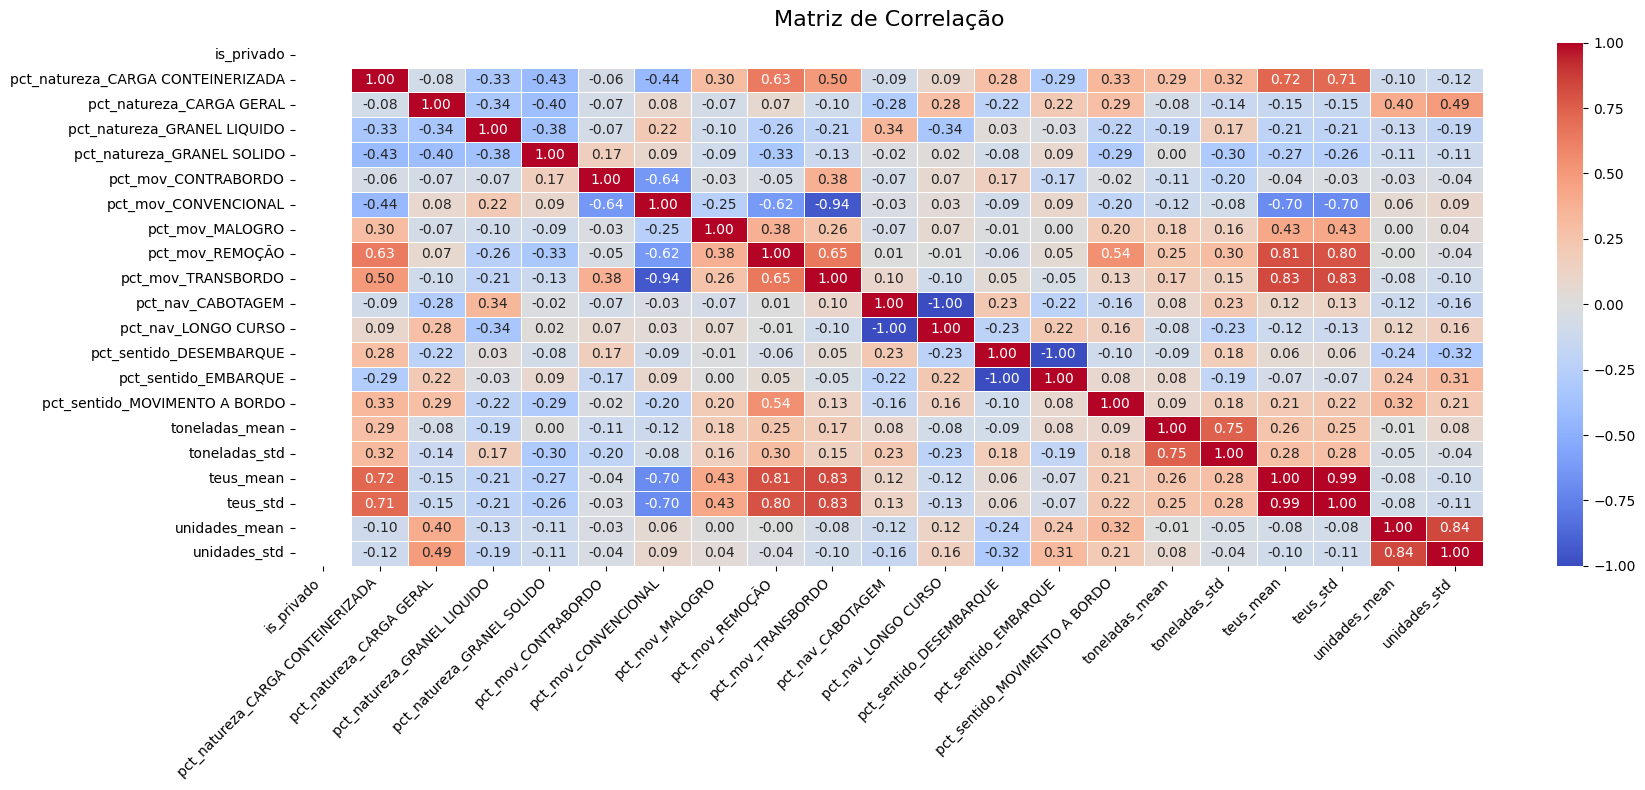

In [ ]:
corr_matrix = features_scaled.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 10}
)

plt.title("Matriz de Correlação", fontsize=16, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Observando o gráfico acima percebemos muitas variáveis com correlação alta e até perfeita em algumas sendo positiva ou negativa, isso é perfeitamente normal dado a como foi gerado todas essas variáveis de proporções (pct_natureza_, pct_mov_, pct_nav_, pct_sentido_), cada grupo de colunas soma 1 para cada terminal, o que gera multicolinearidade direta (um vetor de proporções é linearmente dependente dos outros). Além disso, as estatísticas numéricas (média e desvio de toneladas, teus, unidades) tendem a se correlacionar entre si quando refletem padrões similares de volume ou movimentação.

Ainda sim isso pode distorcer os algoritmos baseados em distância, como K-means e clustering hierárquico que seram usados mais para frente.

**Calculando a VIF (Variance Inflation Factor) para verificar a multicolinearidade**

In [ ]:
f_const = sm.add_constant(features_scaled)

vif_data = pd.DataFrame({
    'Variável': f_const.columns,
    'VIF': [variance_inflation_factor(f_const.values, i) for i in range(f_const.shape[1])]
})

display(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



,Variável,VIF
0,const,0.000000
1,is_privado,NaN
2,pct_natureza_CARGA CONTEINERIZADA,inf
3,pct_natureza_CARGA GERAL,inf
4,pct_natureza_GRANEL LIQUIDO,inf
5,pct_natureza_GRANEL SOLIDO,inf
6,pct_mov_CONTRABORDO,inf
7,pct_mov_CONVENCIONAL,inf
8,pct_mov_MALOGRO,inf
9,pct_mov_REMOÇÃO,inf


Análisando o dataframe acima a variável binária “is_privado” aparece com VIF NaN porque possui variância zero e as as variáveis do tipo “pct_natureza_”, “pct_mov_”, “pct_nav_” e “pct_sentido_” apresentam VIF infinito porque cada conjunto de colunas de proporções soma a 1 para cada terminal, gerando dependência linear perfeita entre elas, nas variáveis numéricas contínuas, observa‐se VIFs mais moderados, embora ainda elevados para “teus_mean” (≈108,6) e “teus_std” (≈81,6). Esses valores indicam que existe forte correlação entre a média e o desvio padrão de TEUs, terminais que movimentam muitos TEUs em média também têm grande variabilidade nesse fluxo. Para “toneladas_mean” e “toneladas_std”, os VIFs de 4,27 e 4,87, respectivamente, mostram correlação moderada sendo o desvio padrão de toneladas está relacionado à média, mas não de forma tão intensa quanto no caso dos TEUs. Já “unidades_mean” (≈3,98) e “unidades_std” (≈4,29) também exibem multicolinearidade moderada, sugerindo que, quanto maior o movimento médio em unidades, maior tende a ser sua dispersão, mas sem chegar a níveis críticos de dependência.

Para garantir que essas variáveis não distorcam os modelos, iremos aplicar o PCA.

**Determinando o número mínimo de componentes do PCA necessários para explicar 100 % da variância em features_scaled**



In [ ]:
pca_full = PCA()
pca_full.fit(features_scaled)
var_ratio = pca_full.explained_variance_ratio_
var_acumulada = var_ratio.cumsum()
print("Variância acumulada para cada número de componentes:")
for i, var in enumerate(var_acumulada, start=1):
    print(f"  {i} componentes → {var:.4f}")

try:
    n_para_1 = next(i for i, v in enumerate(var_acumulada, start=1) if v >= 0.9999)
except StopIteration:
    n_para_1 = len(var_acumulada)
    print("\nNenhum conjunto de componentes explica 100% da variância; usando todas as componentes.")

Variância acumulada para cada número de componentes:
  1 componentes → 0.9758
  2 componentes → 0.9879
  3 componentes → 0.9982
  4 componentes → 0.9993
  5 componentes → 0.9996
  6 componentes → 0.9997
  7 componentes → 0.9998
  8 componentes → 0.9999
  9 componentes → 0.9999
  10 componentes → 1.0000
  11 componentes → 1.0000
  12 componentes → 1.0000
  13 componentes → 1.0000
  14 componentes → 1.0000
  15 componentes → 1.0000
  16 componentes → 1.0000
  17 componentes → 1.0000
  18 componentes → 1.0000
  19 componentes → 1.0000
  20 componentes → 1.0000
  21 componentes → 1.0000


10 componentes são o suficiente para explicar muito próximo de 100% da variância de feauteres_scaled

In [ ]:
n_componentes = 10
pca_10 = PCA(n_components=n_componentes)

X_pca_10 = pca_10.fit_transform(features_scaled)

colunas_pca_10 = [f'PC{i+1}' for i in range(n_componentes)]
df_pca_10 = pd.DataFrame(X_pca_10, columns=colunas_pca_10, index=features_scaled.index)

variancia_explicada_10 = pca_10.explained_variance_ratio_
print("Variância explicada por cada um dos 10 PCs:")
for i, var in enumerate(variancia_explicada_10, start=1):
    print(f"  PC{i:2d}: {var:.4f}")
print(f"\nVariância acumulada até 10 PCs: {variancia_explicada_10.cumsum()[-1]:.4f}")

Variância explicada por cada um dos 10 PCs:
  PC 1: 0.9758
  PC 2: 0.0121
  PC 3: 0.0103
  PC 4: 0.0011
  PC 5: 0.0003
  PC 6: 0.0002
  PC 7: 0.0001
  PC 8: 0.0001
  PC 9: 0.0000
  PC10: 0.0000

Variância acumulada até 10 PCs: 1.0000


In [ ]:
display(df_pca_10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-40.089152,-4.331087,-7.888203,-0.471468,-0.035891,-1.973072,0.136958,-0.047595,-1.020223,-1.044432
1,-40.097574,-3.534472,-7.408582,-1.037779,-0.156001,-1.840523,-0.194946,-0.057190,-1.242025,-0.434730
2,-40.102530,-4.351781,-8.044324,-0.441786,-2.251572,3.168808,0.485240,0.361334,0.059913,0.897369
3,-40.104187,-4.336051,-8.052186,-0.433029,-2.635072,3.842811,-0.544500,-0.379944,0.313776,0.406673
4,-40.105477,-4.332900,-8.063311,-0.429689,-2.831462,4.240552,-0.713083,-0.539811,0.440346,0.545384
...,...,...,...,...,...,...,...,...,...,...
69,-37.370187,-1.539993,-5.766530,3.378982,1.415426,-0.433628,-0.992096,-0.936006,1.531347,-0.815044
70,-40.100259,-4.368833,-8.035498,-0.471641,-1.827992,2.418510,1.531491,1.163975,-0.131328,0.848981
71,-40.106623,-4.317156,-8.054927,-0.375425,-3.047057,4.709114,-1.299677,-0.916183,0.272046,1.245316
72,-40.088984,-4.327457,-7.874076,-0.440763,0.015184,-2.042838,0.148707,-0.020728,-1.309102,-0.391214


**Verificando mais uma vez o VIF (Variance Inflation Factor) para verificar a multicolinearidade**

In [ ]:
f_const = sm.add_constant(df_pca_10)

vif_data = pd.DataFrame({
    'Variável': f_const.columns,
    'VIF': [variance_inflation_factor(f_const.values, i) for i in range(f_const.shape[1])]
})

display(vif_data)

,Variável,VIF
0,const,1.0
1,PC1,1.0
2,PC2,1.0
3,PC3,1.0
4,PC4,1.0
5,PC5,1.0
6,PC6,1.0
7,PC7,1.0
8,PC8,1.0
9,PC9,1.0


tudo certo, podemos continuar para os modelos de agrupamento

# MODELOS

**Comparação de métodos do Hierárquico para escolher o que tiver o cophenético mais próximo de 1**

In [ ]:
metodos = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
D = pdist(df_pca_10, metric='euclidean')
resultados = []

for m in metodos:
    Z = linkage(df_pca_10, method=m)
    c, _ = cophenet(Z, D)
    resultados.append({'Método': m, 'Cophenético': c})

melhor_metodo_hier = pd.DataFrame(resultados).sort_values(by='Cophenético', ascending=False)
display(melhor_metodo_hier)

,Método,Cophenético
3,weighted,0.993257
5,median,0.992703
2,average,0.988549
4,centroid,0.988523
0,single,0.980604
1,complete,0.965122
6,ward,0.929390


Método "weighted" foi o vencedor com cophenético 0.993257, muito próximo de 1, utilizamos o Hierárquico com esse método na comparação com o K-means

In [ ]:
resultados = []
cluster_range = range(2, 11)
for K in cluster_range:
    # Hierárquico “weighted”
    Z_weighted = linkage(df_pca_10, method='weighted')
    labels_weighted = fcluster(Z_weighted, t=K, criterion='maxclust')
    sil_weighted = silhouette_score(df_pca_10, labels_weighted)
    dbi_weighted = davies_bouldin_score(df_pca_10, labels_weighted)
    ch_weighted  = calinski_harabasz_score(df_pca_10, labels_weighted)

    # K-Means
    kmeans = KMeans(n_clusters=K, random_state=42).fit(df_pca_10)
    labels_km = kmeans.labels_
    sil_km = silhouette_score(df_pca_10, labels_km)
    dbi_km = davies_bouldin_score(df_pca_10, labels_km)
    ch_km  = calinski_harabasz_score(df_pca_10, labels_km)
    inertia_km = kmeans.inertia_


    resultados.append({
        'Método': 'hierárquico (weighted)',
        'K': K,
        'Silhouette': sil_weighted,
        'DBI': dbi_weighted,
        'CH': ch_weighted
    })
    resultados.append({
        'Método': 'KMeans',
        'K': K,
        'Silhouette': sil_km,
        'DBI': dbi_km,
        'CH': ch_km
    })

df_comparacao = pd.DataFrame(resultados)
display(df_comparacao)

,Método,K,Silhouette,DBI,CH
0,hierárquico (weighted),2,0.944255,0.030857,354.658139
1,KMeans,2,0.944255,0.030857,354.658139
2,hierárquico (weighted),3,0.838415,0.064878,329.429443
3,KMeans,3,0.856740,0.259959,877.775492
4,hierárquico (weighted),4,0.837802,0.174553,964.419223
5,KMeans,4,0.700131,0.385384,781.590051
6,hierárquico (weighted),5,0.651258,0.340571,1012.580719
7,KMeans,5,0.728599,0.387159,757.947764
8,hierárquico (weighted),6,0.631846,0.353959,883.482302
9,KMeans,6,0.734909,0.324758,1928.158185


# Gráfico de comparação do Silhouette Score - 10 clusters (hierárquico (weighted)	 vs KMeans)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



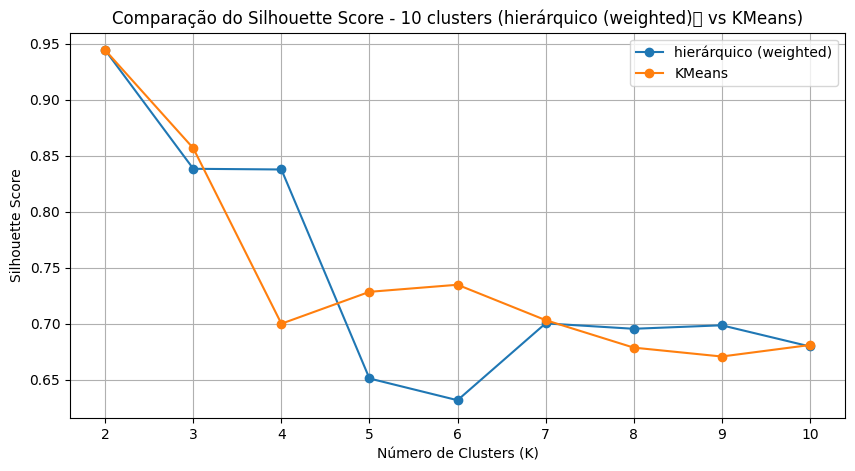

In [ ]:
plt.figure(figsize=(10, 5))
for metodo in ['hierárquico (weighted)', 'KMeans']:
    subset = df_comparacao[df_comparacao['Método'] == metodo]
    plt.plot(subset['K'], subset['Silhouette'], marker='o', label=metodo)

plt.title("Comparação do Silhouette Score - 10 clusters (hierárquico (weighted)	 vs KMeans)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

Nesse gráfico é possível perceber que o método hierárquico weighted e o k-means exibem um desempenho muito próximo quando o número de clusters é igual a 2, refletindo uma pontuação de silhouette praticamente idêntica e bastante elevada, quase 0,95, indicando que ambos os métodos conseguem agrupar as amostras de forma muito coesa e bem separada nesse cenário onde o número de clusters seria 2, a partir de três clusters há uma queda acentuada na pontuação de silhouette tanto para o hierárquico quanto para o k-means, porém o k-means mantém-se ligeiramente à frente, com valor em torno de 0,855, enquanto o hierárquico weighted fica próximo de 0,838, indicando que ao introduzir um terceiro agrupamento o k-means consegue manter uma separação interna dos clusters um pouco melhor que o método hierárquico.

avançando para quatro clusters nota-se que o método hierárquico weighted apresenta ligeira estabilidade na pontuação (aproximando-se de 0,838 novamente), enquanto o k-means sofre uma queda maior, chegando a cerca de 0,698, sugerindo que nesse ponto o agrupamento do hierárquico mantém as amostras mais coerentes em seus respectivos clusters do que o k-means, aumentando ainda mais para cinco clusters o silhouette do hierárquico weighted despenca para aproximadamente 0,647, enquanto o k-means exibe leve melhora para cerca de 0,725, indicando que a divisão em cinco subgrupos favorece momentaneamente o k-means em termos de separação interna.

considerando seis clusters o hierárquico weighted atinge seu valor mínimo, próximo de 0,628, ao passo que o k-means permanece em torno de 0,732, reforçando a ideia de que para maiores divisões o k-means produz agrupamentos com silhuetas melhores, enquanto o hierárquico sofre para manter a distância entre clusters e a coesão dentro deles, a parti daqui, conforme aumenta o número de clusters,tanto o método hierárquico weighted quanto o k-means  possuem desempenho bem similar ficando entre 0,65 e chegando perto de 0,70.

# Gráfico de comparação do DBI - 10 clusters (hierárquico (weighted)	 vs KMeans)

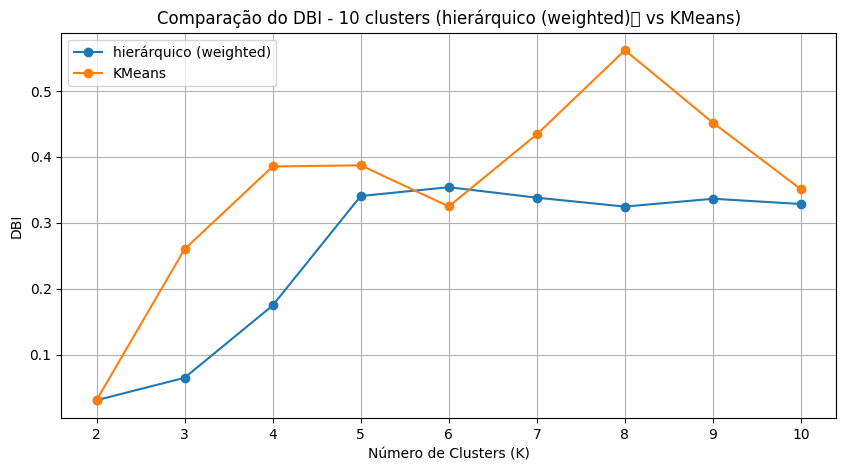

In [ ]:
plt.figure(figsize=(10, 5))
for metodo in ['hierárquico (weighted)', 'KMeans']:
    subset = df_comparacao[df_comparacao['Método'] == metodo]
    plt.plot(subset['K'], subset['DBI'], marker='o', label=metodo)

plt.title("Comparação do DBI - 10 clusters (hierárquico (weighted)	 vs KMeans)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("DBI")
plt.legend()
plt.grid(True)
plt.show()

Ao observar K igual a 2 nota‐se que ambos os métodos apresentam valores de DBI muito baixos próximos de 0,03 indicando que tanto o hierárquico weighted quanto o k‐means geram agrupamentos bem distintos e coesos nesse nível de divisão, sugerindo excelente separação entre clusters, K igual a 3 o DBI do hierárquico weighted aproxima‐se de 0,065 enquanto o k‐means salta para em torno de 0,26 evidenciando que o método hierárquico mantém índices de compactação e separação significativamente melhores que o k‐means ao introduzir o terceiro cluster

Observando quando K é igual a 4 nota-se que o DBI do hierárquico weighted fica em cerca de 0,173 e o do k‐means em torno de 0,385 indicando que o hierárquico continua gerando agrupamentos de qualidade superior, mantendo clusters mais bem definidos e coesos em comparação ao k‐means. K igual a 5 o DBI do hierárquico weighted sobe para aproximadamente 0,339 enquanto o do k‐means fica em torno de 0,387 sinalizando que embora ambos percam um pouco de qualidade nas separações, o hierárquico ainda consegue um leve desempenho melhor que o k‐means

K igual a 6 o DBI do hierárquico weighted atinge cerca de 0,354 e o do k‐means cai levemente para por volta de 0,327 mostrando que nesse nível o k‐means produz clusters um pouco mais balanceados em termos de coesão interna e distância entre grupos, invertendo a vantagem vista nos Ks anteriores, porém volta a subir logo em seguida quando o K está igual a 7, enquanto o hierárquico se mantém constante por volta de 0,35, conforme o número de K vai se apróximando de 10.

# Gráfico de comparação do CH - 10 clusters (hierárquico (weighted)	 vs KMeans)

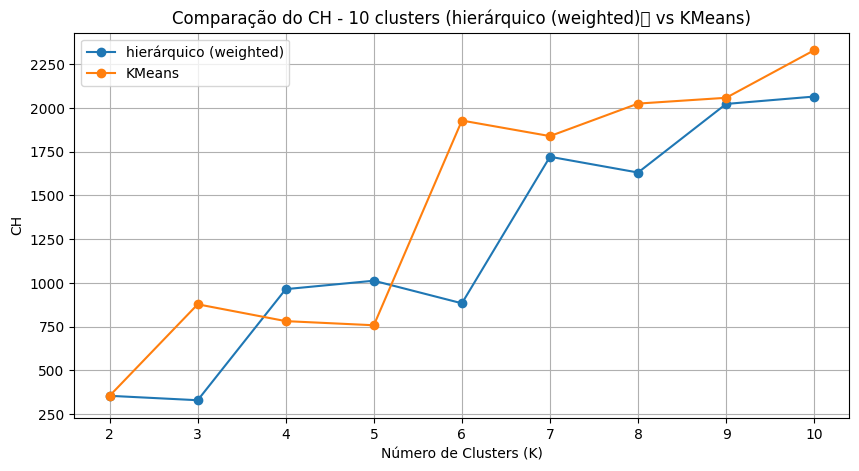

In [ ]:
plt.figure(figsize=(10, 5))
for metodo in ['hierárquico (weighted)', 'KMeans']:
    subset = df_comparacao[df_comparacao['Método'] == metodo]
    plt.plot(subset['K'], subset['CH'], marker='o', label=metodo)

plt.title("Comparação do CH - 10 clusters (hierárquico (weighted)	 vs KMeans)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("CH")
plt.legend()
plt.grid(True)
plt.show()

Considerar K igual a 2 nota‐se que tanto o hierárquico weighted quanto o k‐means apresentam valores de CH próximos de 350 indicando que a separação entre clusters ainda é pouco expressiva em ambos os métodos quando há apenas duas partições. Para K igual a 3 observa‐se que o CH do k‐means salta para aproximadamente 880 enquanto o hierárquico weighted cai para cerca de 330 sugerindo que a divisão em três clusters favorece muito mais o k‐means em termos de dispersão entre grupos e coesão interna nesse ponto

Ao chegar em K igual a 4 o método hierárquico weighted atinge um CH próximo de 970 ao passo que o k‐means fica em torno de 780 indicando que o hierárquico recupera vantagem ao formar quatro clusters, gerando partições mais equilibradas e bem separadas, K igual a 5 o CH do hierárquico weighted segue em alta, aproximando‐se de 1010 enquanto o k‐means permanece em torno de 760 demonstrando que o método hierárquico continua gerando agrupamentos ligeiramente mais consistentes do que o k‐means ao subdividir em cinco grupos

Quando o K igual a 6 nota‐se que o k‐means dispara para um CH em torno de 1910 enquanto o hierárquico weighted cai para aproximadamente 880 sinalizando que nessa granularidade o k‐means encontra partições com maior separação entre clusters e melhor compacidade interna, os dois continuando subindo onde o K-means atinge o pico quando K é igual a 10 com CH acima dos 2250, enquanto o hierárquico weighted está com CH perto de 2000.

Ao considerar de forma integrada as três métricas (Silhouette, DBI e CH), na comparação de cada modelo de agrupamento, percebemos que para poucos clusters (K de 2 a cerca de 4 ou 5), o agrupamento hierárquico weighted tende a gerar partições mais coesas e bem separadas (DBI mais baixo e CH competitivo), mesmo quando o K-means chega a apresentar picos na silhueta em determinados pontos e observando principalmente o gráfico da Silhouette vemos que número ótimo de K seria 3 clusters, então seguiremos com o hierárquico weighted como nosso modelo de agrupamento vencedor para fazer os clusters, antes disso vamos visualizar o dendrogram para ter certeza que 3 clusters é o número ideal.

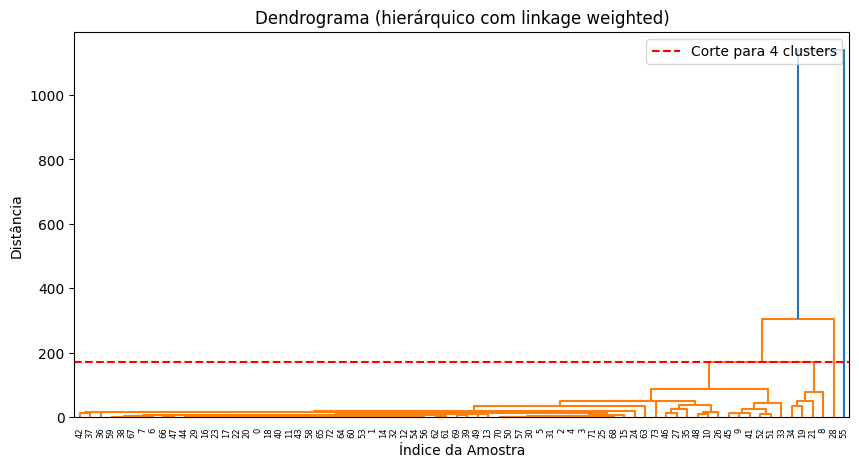

In [ ]:
Z = linkage(df_pca_10, method='weighted')

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrograma (hierárquico com linkage weighted)')
plt.xlabel('Índice da Amostra')
plt.ylabel('Distância')

plt.axhline(y=Z[-3, 2], color='r', linestyle='--', label='Corte para 4 clusters')
plt.legend()
plt.show()

Análisando o dendrograma percebemos claramente três ramos principais quando cortamos na linha tracejada vermelha (distância≈175), o que confirma visualmente a escolha de K= 4. Abaixo desse corte, cada um dos três grandes blocos agrupa diversas folhas (amostras) com distâncias internas muito pequenas (incrementos quase “planos” próximos de zero), indicando alta coesão dentro de cada cluster. Já acima da linha, há um salto considerável na distância de fusão, provando que, a partir desse ponto, unir dois desses grandes grupos degradaria muito a homogeneidade interna. Em outras palavras, a estrutura hierárquica sugere que existem três subárvores bem definidas e bem separadas entre si, com níveis de fusão internos bastante compactos e, somente depois, uma fusão de alta distância que une esses três principais conjuntos.

In [ ]:
Z = linkage(df_pca_10, method='weighted')

labels = fcluster(Z, t=4, criterion='maxclust')

df_clusters = df_pca_10.copy()
df_clusters['cluster'] = labels
df_clusters.insert(0, 'terminal - gerin', terminais)

display(df_clusters)

,terminal - gerin,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster
0,ACT (ARM 38),-40.089152,-4.331087,-7.888203,-0.471468,-0.035891,-1.973072,0.136958,-0.047595,-1.020223,-1.044432,2
1,ADM,-40.097574,-3.534472,-7.408582,-1.037779,-0.156001,-1.840523,-0.194946,-0.057190,-1.242025,-0.434730,2
2,ADONAI,-40.102530,-4.351781,-8.044324,-0.441786,-2.251572,3.168808,0.485240,0.361334,0.059913,0.897369,2
3,AGEO,-40.104187,-4.336051,-8.052186,-0.433029,-2.635072,3.842811,-0.544500,-0.379944,0.313776,0.406673,2
4,AGEO LESTE,-40.105477,-4.332900,-8.063311,-0.429689,-2.831462,4.240552,-0.713083,-0.539811,0.440346,0.545384,2
...,...,...,...,...,...,...,...,...,...,...,...,...
69,USIMINAS,-37.370187,-1.539993,-5.766530,3.378982,1.415426,-0.433628,-0.992096,-0.936006,1.531347,-0.815044,2
70,VOPAK (ALAMOA),-40.100259,-4.368833,-8.035498,-0.471641,-1.827992,2.418510,1.531491,1.163975,-0.131328,0.848981,2
71,VOPAK (ILHA),-40.106623,-4.317156,-8.054927,-0.375425,-3.047057,4.709114,-1.299677,-0.916183,0.272046,1.245316,2
72,tec,-40.088984,-4.327457,-7.874076,-0.440763,0.015184,-2.042838,0.148707,-0.020728,-1.309102,-0.391214,2


**Para interpretar os clusters, iremos adiciona-los ao dataset original atráves da coluna terminal-gerin**

In [ ]:
df_original = df.merge(
    df_clusters[['terminal - gerin', 'cluster']],
    on='terminal - gerin',
    how='left'
)
display(df_original)

,ano,mês,desc_simples,tipo_instalação (grupos),terminal - gerin,naturezacarga,tipo_movimento,navegacao,sentido_carga,desc_spa,toneladas,teus,unidades,data,year,cluster
0,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),1.077,0,0,2005-01-01,2005,2
1,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,19.980,0,0,2005-01-01,2005,2
2,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),4.307,0,0,2005-01-01,2005,2
3,2005,1,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,79.919,0,0,2005-01-01,2005,2
4,2005,1,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,29.357,0,0,2005-01-01,2005,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288405,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,11.000,0,15,2025-02-01,2025,2
288406,2025,2,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,VEÍCULOS AUTOMÓV,1.182,0,285,2025-02-01,2025,2
288407,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,OUTRAS MERCADORI,159.000,14,8,2025-02-01,2025,2
288408,2025,2,VALONGO,PORTO ORGANIZADO,OUTROS,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,DESEMBARQUE,PRODUTOS DIVERSO,13.000,1,1,2025-02-01,2025,2


**Verificando a quantidade de cada cluster no conjunto de dados**

In [ ]:
df_original['cluster'].value_counts()

,count
cluster,
2,286719
1,1625
4,44
3,22


**Interpretação dos clusters**

In [ ]:
counts_clusters_nc = df_original.groupby(['cluster', 'naturezacarga']).size().unstack(fill_value=0)

percent_clusters_nc = counts_clusters_nc.div(counts_clusters_nc.sum(axis=1), axis=0) * 100


print("             Porcentagem de cada natureza de carga em cada cluster (%)")
display(percent_clusters_nc.round(2))



             Porcentagem de cada natureza de carga em cada cluster (%)


naturezacarga,CARGA CONTEINERIZADA,CARGA GERAL,GRANEL LIQUIDO,GRANEL SOLIDO
cluster,,,,
1,0.80,26.15,0.00,73.05
2,83.14,4.77,8.07,4.03
3,0.00,100.00,0.00,0.00
4,0.00,100.00,0.00,0.00


# Gráfico da distribuição percentual de natureza de carga em cada cluster

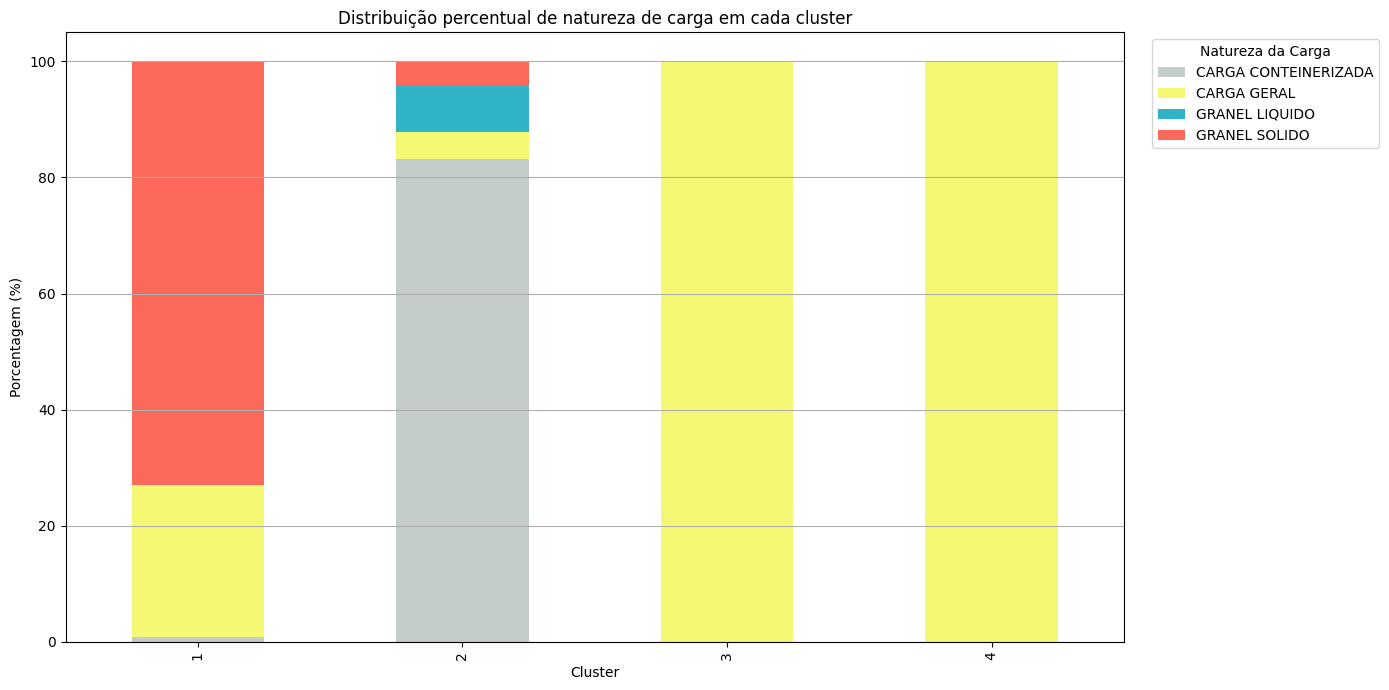

In [ ]:
cores = {
    'CARGA CONTEINERIZADA': '#c4cdcc',
    'GRANEL LIQUIDO': '#30b2c7',
    'CARGA GERAL': '#f4f872',
    'GRANEL SOLIDO': '#fc6859'
}
percent_clusters_nc.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    color=[cores[col] for col in percent_clusters_nc.columns]

)
plt.xlabel('Cluster')
plt.ylabel('Porcentagem (%)')
plt.title('Distribuição percentual de natureza de carga em cada cluster')
plt.legend(title='Natureza da Carga', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.grid(axis='y')
plt.show()

No primeiro agrupamento percebe‐se que a esmagadora maioria da movimentação é de granel sólido (73,05%), indicando que os terminais desse cluster concentram‐se em operações que envolvem esse tipo de carga. Há uma porção menor de carga geral (26,15%), sugerindo que, outro tipo de carga além dos graneis sólidos, mas ainda sim, secundário em relação ao volume de sólidos. A participação de carga conteinerizada praticamente inexiste (0,80%), o que reforça a especialização desses terminais em granel sólido, com fluxo de contêineres quase desprezível.

No segundo agrupamento, temos um cénario quase o oposto em relação ao primeiro, a carga conteinerizada domina de forma quase absoluta (83,14%), sinalizando que esses terminais são especializados em operações de contêineres, há ainda uma pequena fração de granel líquido (8,07%) A presença reduzida de granel sólido indica que esse grupo de terminais não dá prioridade a minério ou produtos sólidos em grande escala. A presença reduzida de granel sólido (4,03%) indica que esse grupo de terminais não dá prioridade esse tipo carga, o mesmo ocorre para carga geral (4,77%), vale ressaltar que esse é o agrupamento com maior número de terminais em comparação com os outros três por isso ele possue todos os tipos de carga.

Os dois últimos agrupamentos exibem composição 100% formada por carga geral, o que revela que eles se dedicam exclusivamente a esse tipo de carga.

In [ ]:
counts_clusters_tm = df_original.groupby(['cluster', 'tipo_movimento']).size().unstack(fill_value=0)

percent_clusters_tm  = counts_clusters_tm.div(counts_clusters_tm.sum(axis=1), axis=0) * 100


print("             Porcentagem de cada Tipo de movimento da carga em cada cluster (%)")
display(percent_clusters_tm.round(2))


             Porcentagem de cada Tipo de movimento da carga em cada cluster (%)


tipo_movimento,CONTRABORDO,CONVENCIONAL,MALOGRO,REMOÇÃO,TRANSBORDO
cluster,,,,,
1,0.12,99.14,0.12,0.06,0.55
2,0.34,64.24,0.13,7.95,27.34
3,0.00,100.00,0.00,0.00,0.00
4,0.00,97.73,0.00,2.27,0.00


# Gráfico da distribuição percentual do Tipo de movimento da carga em cada cluster

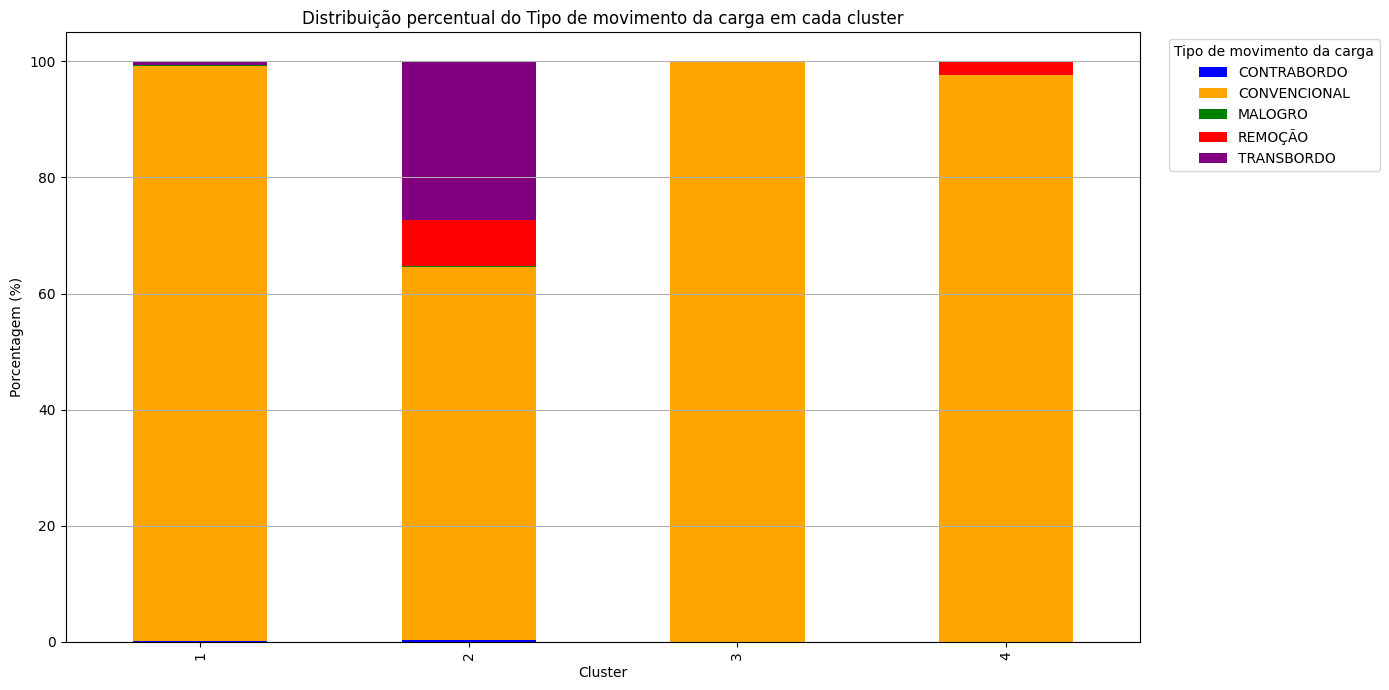

In [ ]:
cores = {
    'CONTRABORDO': 'blue',
    'CONVENCIONAL': 'orange',
    'MALOGRO': 'green',
    'REMOÇÃO': 'red',
    'TRANSBORDO': 'purple'
}
percent_clusters_tm.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    color=[cores[col] for col in percent_clusters_tm.columns]
)
plt.xlabel('Cluster')
plt.ylabel('Porcentagem (%)')
plt.title('Distribuição percentual do Tipo de movimento da carga em cada cluster')
plt.legend(title='Tipo de movimento da carga', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.grid(axis='y')
plt.show()

No primeiro Agrupamento observa‐se que quase toda a movimentação de carga é feita por meio convencional (99,14%), indicando que esses terminais operam basicamente com descarga e embarque sem transbordo significativo (0,55%).

No segundo Agrupamento há uma predominância de carga movimentada convencionalmente (64,24%), porém com uma parcela importante de transbordo (27,34%) e uma menor parcela de remoção(7,95%).

No terceiro Agrupamento constata‐se que a participação de todos os tipos de movimentação está restrita à modalidade convencional sendo 100%.

No quarto Agrupamento, novamente predomina a movimentação convencional (97,73%), embora exista uma pequena parcela de remoção (2,27%).

In [ ]:
counts_clusters_sc = df_original.groupby(['cluster', 'sentido_carga']).size().unstack(fill_value=0)

percent_clusters_sc  = counts_clusters_sc.div(counts_clusters_sc.sum(axis=1), axis=0) * 100


print("             Porcentagem de cada Sentido da carga em cada cluster (%)")
display(percent_clusters_sc.round(2))

             Porcentagem de cada Sentido da carga em cada cluster (%)


sentido_carga,DESEMBARQUE,EMBARQUE,MOVIMENTO A BORDO
cluster,,,
1,2.09,97.91,0.00
2,50.80,48.75,0.44
3,0.00,100.00,0.00
4,0.00,97.73,2.27


# Gráfico da distribuição percentual do Sentido da carga em cada cluster

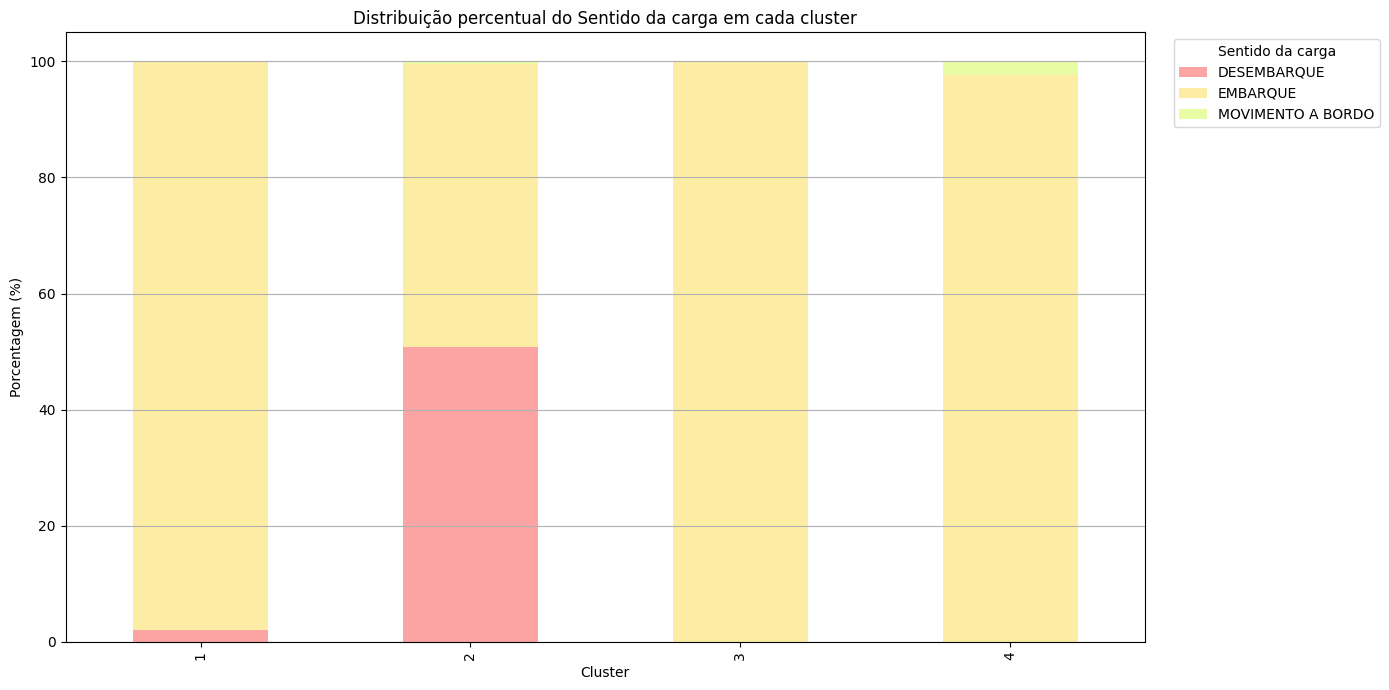

In [ ]:
cores = {
    'DESEMBARQUE': '#fca4a4',
    'EMBARQUE': '#fceca4',
    'MOVIMENTO A BORDO': '#e8fca4'
}

percent_clusters_sc.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    color=[cores[col] for col in percent_clusters_sc.columns]
)
plt.xlabel('Cluster')
plt.ylabel('Porcentagem (%)')
plt.title('Distribuição percentual do Sentido da carga em cada cluster')
plt.legend(title='Sentido da carga', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.grid(axis='y')
plt.show()

No primeiro Agrupamento evidencia‐se que esses terminais operam praticamente como pontos de saída de cargas, uma vez que quase toda a movimentação se dá no sentido de embarque(97,91%), com 2,09% sendo de desembarque e nenhum movimento a bordo.

No Segundo Agrupamento temos uma divisão quase equilibrada entre embarque (48,75%) e desembarque (50,80%), com uma miníma parcela de movimento abordo (0,44%)

Observando terceiro Agrupamento nota‐se um padrão homogêneo em que tudo o que entra se destina a partir em sentido de embarque (100%), sem nenhuma movimentação de desembarque ou operações a bordo.

No quarto Agrupamento observa‐se que quase toda a atividade concentra‐se em embarque (97,73%), com uma pequena fração de movimentação a bordo (2,27%) e 0 desembarques.

# Resumo Estatístico das Variáveis por Cluster

In [ ]:
resumo_est_clusters = (
    df_original
    .groupby('cluster')[['toneladas', 'teus', 'unidades']]
    .agg(['mean', 'std', 'median'])
)

display(resumo_est_clusters)


toneladas                             teus                     \
               mean         std   median        mean         std median   
cluster                                                                   
1        208.935626  208.259246  140.000    0.160615    2.838758    0.0   
2        142.965671  219.082445   37.000  254.255452  996.917825    9.0   
3         71.420364   65.010731   59.275    0.000000    0.000000    0.0   
4         66.423432  123.311045   30.694    0.000000    0.000000    0.0   

              unidades                           
                  mean            std    median  
cluster                                          
1        100442.060308  268700.125380       0.0  
2           491.066225    9232.158332       8.0  
3        185559.409091  513287.936819   31873.5  
4        675327.204545  519975.328527  555000.0

No primeiro Agrupamento observa‐se que o tonelado médio é o mais elevado entre os grupos, com cerca de 208 toneladas por operação, apesar de um desvio‐padrão também alto, o que indica que alguns terminais movimentam volumes muito maiores, enquanto a mediana (140 toneladas) sinaliza que a maioria lida com valores próximos a esse. A movimentação de contêineres é praticamente inexistente, pois a média de 0,16 TEUs e a mediana zero mostram que raramente entram ou saem contêineres nesses terminais.

Já no quesito unidades nota‐se um valor médio em torno de 100 mil unidades, porém com desvio‐padrão muito grande e mediana zero, o que revela que apenas alguns terminais de agrupamento lidam com grande volume de unidades, enquanto a maioria tem pouca ou nenhuma.

No segundo Agrupamento o panorama muda, pois apesar de ainda haver movimentação em toneladas (média de 143 toneladas e mediana 37, com alto desvio), o destaque fica para os contêineres, onde a média de 254 TEUs mostra que muitos terminais desse grupo atuam fortemente em operações conteinerizadas, embora o desvio‐padrão elevado e a mediana de 9 TEUs indiquem grande variabilidade entre terminais, alguns lidam com milhares de TEUs, já outros com praticamente nada. As unidades (média de 491 unidades e mediana 8) também aparecem, mas de forma muito menos expressiva e bastante irregular, conforme o alto desvio‐padrão (mais de 9 mil).

No terceiro agrupamento temos o valor médio de toneladas (71) e a mediana (59) em menor escala que nos agrupamentos anteriores, enquanto o movimento de contêineres é nulo, pois tanto média quanto mediana de TEUs são zero. Em contrapartida, as unidades registram média de 185 mil e mediana de aproximadamente 31 mil, com desvio‐padrão elevadíssimo (mais de 513 mil), o que demonstra que alguns terminais dentro de agrupamento movimentam quantidades extraordinárias de unidades, enquanto outros operam muito pouco.

Por fim, no quarto agrupamento nota‐se a menor média de toneladas (66) entre os agrupamentos anteriores e a mediana de cerca de 31 toneladas. Não há movimentação de contêineres, pois a média e mediana de TEUs são zero. Já as unidades apresentam a média mais alta (675 mil) e a mediana bastante elevada (555 mil), com desvio‐padrão considerável, o que evidencia que a maioria dos terminais movimentam grandes quantidades de unidades, com uma variabilidade significativa entre terminais.

# **CONSIDERAÇÕES FINAIS**

Os terminais do primeiro agrupamento, definidos pela forte predominância de granel sólido e movimentação quase exclusivamente convencional voltada para embarque, mostram‐se indicados para gerir grandes volumes de commodities como minério ou grãos. Os terminais desse agrupamento poderiam fazer uma cordenação de horários de atracação e dimensionar rebocadores e equipamentos de descarga de forma concentrada em períodos de pico de safra, minimizando vazios de operação e reduzindo filas, pois todos seguem padrões semelhantes de alto tonelado por operação e baixo fluxo conteinerizado.

O segundo agrupamento, essencialmente conteinerizado com relevante parcela de transbordo e remoção, configura‐se como um hub de redistribuição de TEUs, onde metade das operações envolve descarregar contêineres e recarregar cargas para outros destinos. Com base nisso o terminais que pertecem a esse agrupamento podem articular rotas integradas, estabelecer políticas de compartilhamento de pátio para armazenagem temporária e otimizar o sequenciamento de navios que operam transbordo, de modo a evitar gargalos quando vários navios chegam simultaneamente.

Nos dois últimos agrupamentos, exclusivos de carga geral, observam‐se perfis distintos de escala, o terceiro reúne terminais que, apesar de movimentarem unidades em lotes expressivos, o fazem de forma mais heterogênea, enquanto o quarto congrega terminais com fluxos de unidades ainda mais volumosos e concentrados apesar disso, para ambos seria importante contratar serviços de empilhadeiras e automatizar processos de triagem, de modo a reduzir o tempo em pátio.

Para resumir esse projeto vimos que a segmentação dos terminais portuários que pode possibilitar a definição de estratégias específicas para otimizar a logística e reduzir o tempo de espera de navio.